```
AUTHOR: JOSH STINE
DATE CREATED: 3/27/2022
```

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
from collections import defaultdict
import numpy as np
import random as py_random
import numpy.random as np_random
import time
import seaborn as sns
import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp
import pandas as pd
import pandasql as sqldf
import patsy
import random
import scipy.stats as stats
import sklearn.model_selection as model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
import sklearn.linear_model as linear
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tabulate import tabulate

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")

# custom modules
import models

# EDA and Regression Analysis of Electric Vehicles (EVs)

### About the Data
Per the Kaggle Detail about this file: [https://www.kaggle.com/datasets/geoffnel/evs-one-electric-vehicle-dataset](https://www.kaggle.com/datasets/geoffnel/evs-one-electric-vehicle-dataset)

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>CONTEXT</strong>
    <p>This is a dataset of electric vehicles.</p>
    <p>One of the more popular data science datasets is the mtcars dataset. It is known for its simplicity when   running analysis and visualizations.</p>
    <p>When looking for simple datasets on EVs, there don't seem to be any. Also, given the growth in this market, this is something many would be curious about. Hence, the reason for creating this dataset.</p>
    <p>For more information, please visit the data source below.</p>
    <p>This dataset was manually created from the <a href="https://ev-database.org/" target="_blank">https://ev-database.org/</a> website.</p>
</div>


<div style="background: darkturquoise; margin:20px; padding: 20px;">
    <h2>ASK</h2>
    <ol>
        <li>Which manufacturer produces the greatest number of car models?</li>
        <li>Which company produces the most expensive car? Car with the highest average price?</li>
        <li>Which car has the fastest 0-100 acceleration?</li>
        <li>Which has the highest efficiency?</li>
        <li>Does a difference in power train effect the range, top speed, efficiency?</li>
        <li>Which factors (efficiency, rapid charge, range, brand, etc.) have the most influence on price?</li>
    </ol>
</div>


## GET - *ETL in the small*

After coming up with a set of questions that we want to explore, the next part of the EDA process is to *get* the data. Fortunately, the dataset I have decided to explore is already nice and neat. Though it would be possible to break this single .csv file up into a small SQLlite database to structure it more efficiently, I want to take leverage the of the `pandas` library to read in the data. This library works well with the `numpy` and `scipy.stats` libraries for a thorough and efficient EDA.

The `FastCharge_KmH` field is a string that should be represented as numeric field. There are 5 observations with values as `-` because they do not apply because `RapidCharge` is No. If the EV has `RapidCharge` then there is no fast charging capabilities, hence no need for the value. Therefore I will replace these with `None` instead of `0` to not impact any correlation calculations when generating descriptive statistics and plots of the variable comparisons.

In [2]:
evdata = pd.read_csv('evdata/ElectricCarData_Clean.csv')

# convert this field from string to float, replacing the "-" value with None
evdata['FastCharge_KmH'].mask(evdata['FastCharge_KmH']=='-', None, inplace=True)
evdata['FastCharge_KmH'] = pd.to_numeric(evdata['FastCharge_KmH'])

evdata.head()

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940.0,Yes,AWD,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID3 Pure,10.0,160,270,167,250.0,Yes,RWD,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620.0,Yes,AWD,Type 2 CCS,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560.0,Yes,RWD,Type 2 CCS,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190.0,Yes,RWD,Type 2 CCS,Hatchback,B,4,32997


## EXPLORE

So after getting a sneak peak at the data it looks like there are quite a lot of variables to look at. However, we need to keep the research questions in mind when doing the analysis. First we can take a look at the data to see if we are missing any values.

In [3]:
evdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   98 non-null     float64
 7   RapidCharge      103 non-null    object 
 8   PowerTrain       103 non-null    object 
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null    int64  
 13  PriceEuro        103 non-null    int64  
dtypes: float64(2), int64(5), object(7)
memory usage: 11.4+ KB


In [4]:
evdata.head()

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940.0,Yes,AWD,Type 2 CCS,Sedan,D,5,55480
1,Volkswagen,ID3 Pure,10.0,160,270,167,250.0,Yes,RWD,Type 2 CCS,Hatchback,C,5,30000
2,Polestar,2,4.7,210,400,181,620.0,Yes,AWD,Type 2 CCS,Liftback,D,5,56440
3,BMW,iX3,6.8,180,360,206,560.0,Yes,RWD,Type 2 CCS,SUV,D,5,68040
4,Honda,e,9.5,145,170,168,190.0,Yes,RWD,Type 2 CCS,Hatchback,B,4,32997


It looks like there is a good mix of single/multivalued categorical and numerical variables. In order to make the repetitive comparisons more dynamic I have a few *helper* functions, compiled code from course content, within an import called `helper_functions.py` to save code space within the notebook. This module assists in outputting descriptive statistics and plot distributions.

In [5]:
"""Descriptive Stats functions"""
def descriptive_numeric(dataframe, col_name, precision=3):
    ds = pd.DataFrame(dataframe[col_name].describe())
    parametric_stats = {'Range': ds.loc[['max']].values[0] - ds.loc[['min']].values[0],
                        'IQR': + ds.loc[['75%']].values[0] - ds.loc[['25%']].values[0],
                        'COV': + ds.loc[['std']].values[0] / ds.loc[['mean']].values[0]
                       }
    all_stats = pd.concat([ds, pd.DataFrame(parametric_stats).T], axis=1)
    index = {0:'Count', 1:'Mean', 2:'Std', 3:'Min', 4:'Q1', 5:'Med', 6:'Q3', 7:'Max', 8:'Range', 9:'IQR', 10:'COV'}
    return pd.DataFrame(all_stats.stack()).reset_index(drop=True).rename(columns={0:col_name}, index=index)

def descriptive_categorical(dataframe, col_name, cmap1, cmap2=None):  
    data = pd.DataFrame(dataframe[col_name].value_counts(normalize=True).sort_values(ascending=False)*100).reset_index()
    data.rename(columns={'index': col_name, col_name: '% observations'}, inplace=True)
    data['Cumulative %'] = data['% observations'].cumsum()
    data_styled = data.style.background_gradient(cmap=cmap1, subset=['% observations','Cumulative %'])\
        .format(formatter={'% observations': "{:.2f}%", 'Cumulative %':"{:.2f}%"})\
        .hide_index()
    return data_styled

    
def measure_correlation(x, y):
    print("Correlation Statistics")
    print("----------------------")
    print( "r   =", "{:.4f}".format(stats.pearsonr(x, y)[0]))
    print( "rho =", "{:.4f}".format(stats.spearmanr(x, y)[0]))
    
def describe_categorical_numeric(data, numeric, categorical, transpose=False):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    if transpose:
        return pd.DataFrame(grouped_y.transpose())
    else:
        return pd.DataFrame(grouped_y)

"""Plotting functions"""
def freeman_diaconis( data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75]) 
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

def numeric_single_histogram(data, field_name, autobin=False, color='cornflowerblue', plot_quantiles=False, quantile_colors=None):
    if quantile_colors is None:
        quantile_colors=['r', 'maroon', 'r', 'lime']
    figure = plt.figure(figsize=(20, 6))
    axes = figure.add_subplot(1, 2, 1)
    if autobin:
        data_min = int(data.min())
        rng = int(data.max()) - data_min
        step = freeman_diaconis(data)
        bins = [data_min + i for i in range(0, rng, step)]
        axes.hist(data, color=color, bins=bins)
        axes.set_title("Count Histogram of "+ field_name + "; bin size = " + str(step), fontsize=16)
    else:
        axes.hist(data, color=color)
        axes.set_title("Count Histogram of "+ field_name + "; default bins", fontsize=16)
    axes.set_ylabel("Count", fontsize=16)
    axes.set_xlabel(field_name, fontsize=16)
    if plot_quantiles:
        quantiles = np.quantile(data,[0.25, 0.5, 0.75])
        plt.axvline(x = quantiles[0], color = quantile_colors[0], label = 'Q1')
        plt.axvline(x = quantiles[1], color = quantile_colors[1], label = 'Median')
        plt.axvline(x = quantiles[2], color = quantile_colors[2], label = 'Q3')
        plt.axvline(x = data.mean(), color = quantile_colors[3], label = 'Mean')
        plt.legend(loc='best')
    plt.grid(visible=False, axis='both', which='both')
    
    axes = figure.add_subplot(1, 2, 2)
    if autobin:
        axes.hist(data, density=True, color=color, bins=bins)
        axes.set_title("Density Histogram of "+ field_name + "; bin size = " + str(step), fontsize=16)
    else:
        axes.hist(data, density=True, color=color)
        axes.set_title("Density Histogram of " + field_name + "; default bins", fontsize=16)
    axes.set_ylabel("Density", fontsize=16)
    axes.set_xlabel(field_name, fontsize=16)
    if plot_quantiles:
        quantiles = np.quantile(data,[0.25, 0.5, 0.75])
        plt.axvline(x = quantiles[0], color = quantile_colors[0], label = 'Q1')
        plt.axvline(x = quantiles[1], color = quantile_colors[1], label = 'Median')
        plt.axvline(x = quantiles[2], color = quantile_colors[2], label = 'Q3')
        plt.axvline(x = data.mean(), color = quantile_colors[3], label = 'Mean')
        plt.legend(loc='best')
    plt.grid(visible=False, axis='both', which='both')
    plt.show()
    plt.close()
    
    
def lowess_scatter(data, x, y, jitter=0.0, color='DimGray', skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)

    axes.scatter(xs, data[y], marker="o", color=color, alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")
    plt.grid(visible=False, axis='both', which='both')

    title = "Plot of '{0}' vs. '{1}'".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title, fontsize=20)
    axes.set_xlabel(x, fontsize=20)
    axes.set_ylabel(y, fontsize=20)

    plt.show()
    plt.close()
    
    
def overlay_distro_and_scatter(data, x, y, colors=['cornflowerblue','cornflowerblue'], quantile_colors=None, pop_proportion=0.5, fit_colors=None):
    
    figure = plt.figure(figsize=(10, 10))
    axes = figure.add_subplot(2, 1, 1)
    data_min = int(data[y].min())
    rng = int(data[y].max()) - data_min
    step = freeman_diaconis(data[y])
    bins = [data_min + i for i in range(0, rng, step)]
    axes.hist(data[y],bins=bins,color=colors[0])
    quantiles = np.quantile(data[y],[0.25, 0.5, 0.75])
    if quantile_colors is None:
        quantile_colors = ['r', 'orangered', 'r', 'lime']
    plt.axvline(x = quantiles[0], color = quantile_colors[0], label = 'Q1')
    plt.axvline(x = quantiles[1], color = quantile_colors[1], label = 'Median')
    plt.axvline(x = quantiles[2], color = quantile_colors[2], label = 'Q3')
    plt.axvline(x = data[y].mean(), color = quantile_colors[3], label = 'Mean')
    plt.legend(loc='best')
    axes.set_title("'" + y + "'" + " Distribution - Freeman Diaconis", fontsize=16)
    axes.set_xlabel(y, fontsize=16)
    plt.grid(visible=False, axis='both', which='both')
    
    axes = figure.add_subplot(2, 1, 2)
    axes.scatter(data[x], data[y], marker="o", color=colors[1])
    
    if fit_colors is None:
        fit_colors = ['DarkRed','k']
    # plot linear line of best fit
    fit = np.polyfit(data[x], data[y], 1)
    linear_line_x = np.linspace(data[x].min(), data[x].max(), 10)
    linear_line = np.poly1d(fit)
    linear_line_y = list(map(linear_line, linear_line_x))
    axes.plot(linear_line_x, linear_line_y, color=fit_colors[0], label='Linear Fit')
    
    # plot LOWESS line of best fit
    lowess = sm.nonparametric.lowess(data[y], data[x], frac=pop_proportion)
    lowess_line_x = list(zip(*lowess))[0]
    lowess_line_y = list(zip(*lowess))[1]
    axes.plot(lowess_line_x, lowess_line_y, color=fit_colors[1], label='LOWESS Fit')
    plt.legend(loc='best')
    
    axes.set_ylabel(y, fontsize=16)
    axes.set_xlabel(x, fontsize=16)
    axes.set_title("Scatter Plot of '" + x + "' vs. '" + y + "' Whole weight", fontsize=16)
    plt.grid(visible=False, axis='both', which='both')
    plt.tight_layout()
    plt.show()
    plt.close()
    
    
def multiboxplot(data, numeric, categorical, jitter=0.00, skip_data_points=True, figsize=(10, 6), rotation=0):
    figure = plt.figure(figsize=figsize)

    axes = figure.add_subplot(1, 1, 1)

    grouped = data.groupby(categorical)
    labels = pd.unique(data[categorical].values)
    labels.sort()
    grouped_data = [grouped[numeric].get_group( k) for k in labels]
    patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1)
    # eda.restyle_boxplot( patch)

    if not skip_data_points:
        for i, k in enumerate(labels):
            subdata = grouped[numeric].get_group( k)
            x = np.random.normal(i + 1, jitter, size=len(subdata))
            axes.plot(x, subdata, 'o', alpha=0.4, color="r", zorder=2)

    axes.set_xlabel(categorical, fontsize=20)
    axes.set_ylabel(numeric, fontsize=20)
    axes.set_title("Distribution of '{0}' by '{1}'".format(numeric, categorical), fontsize=20)
    plt.xticks(rotation=rotation)

    plt.show()
    plt.close()

## `PriceEuro` target variable

The price in euros is our target variable that will be used to build and test the models so it's important to look at this attribute first.

In [6]:
price = evdata['PriceEuro']
descriptive_numeric(evdata, 'PriceEuro')

,PriceEuro
Count,103.000000
Mean,55811.563107
Std,34134.665280
Min,20129.000000
Q1,34429.500000
Med,45000.000000
Q3,65000.000000
Max,215000.000000
Range,194871.000000
IQR,30570.500000


`PriceEuro` appears to have some right skewedness, with some EVs in the six figure range! Though the range is large, the `IQR` of (€30K) is smaller than the `Std` (€34K) so I suspect a majority of the data is going to show these EVs are concentrated on the left side of the distribution in a more "reasonable" price range from the `min` of €20K to `Q3` of €65. Now we can plot the descriptive stats to see how they look.

In [7]:
plot_colors = mcp.gen_color(cmap='tab20', n=20)

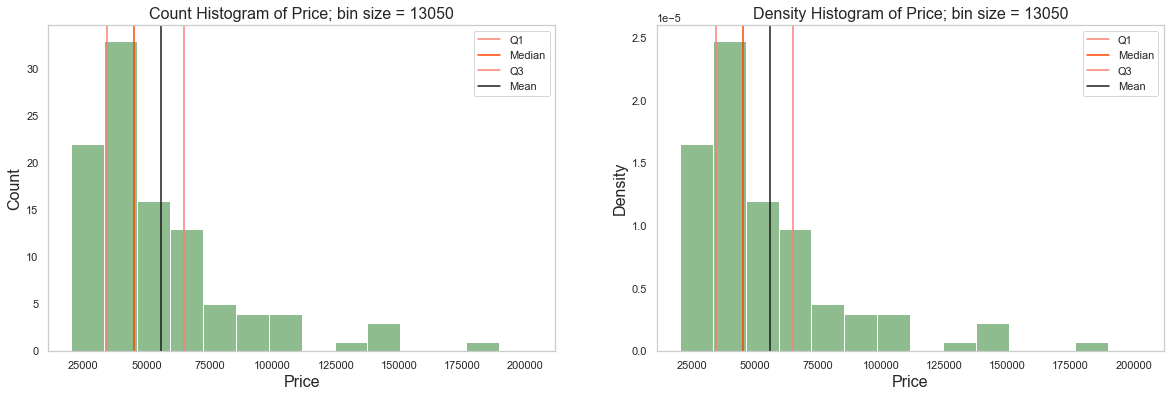

In [8]:
numeric_single_histogram(price, 'Price', autobin=True, plot_quantiles=True, color='darkseagreen', 
                         quantile_colors=['salmon','orangered','salmon','k'])

A majority of the cars will be under €100,000, but the long/thin tail in the histogram distributions show the right skewedness with the mean positioned halfway between the median and Q3 lines. The EVs between €125,000+ appear to be outliers so we will need to keep an eye out for anything interesting plotting the other variables looking for similar patterns or correlations. Before evaluating the variables/features, let's take a look at a Causal Loop Diagram to predict how each variable will impact  `PriceEuro`.

# EV Data Causal Loop Diagram
<img src="evdata_CLD.png" alt="ev_CLD" width="600"/>



I predict all features except `AccelSec` and `Efficiency_WhKm` will have a positive effect on the target variable, PriceEuro. In order for a car to accelerate faster, it will have a lower value of `AccelSec`, therefore increasing the price which has an inverse effect. The same thing is true for `Efficiency_WhKm`. The lower number, the more efficient the car is, which I think will have a positive impact on price. Other features like `FastCharge_KmH` or `TopSpeed_Km`, I think will have a positive relationship with price. That is, the higher values for those features, the higher the price.

## `Brand` variable

We know the dataset contains 103 different EVs with a price range of €20K - €195K, we should next look at which different `Brand` types in the EV market because there could be a correlation between price if some of these are *luxury brands*. 

In [9]:
print('Number of Distinct Brands: ' + str(len(evdata['Brand'].unique())))

Number of Distinct Brands: 33


Ok so there are 33 different brands in the "market basket" of 103 EVs, which would mean roughly 3 cars per manufacturer but it will be interesting to look at the distribution here to see how it actually turns out to be. Here we can look at one of our research questions:

<div style="background: darkturquoise; margin:20px; padding: 20px;">
        <b>Research Question:</b>
        <br> 1. Which manufacturer produces the greatest number of car models?
</div>


In [10]:
descriptive_categorical(dataframe=evdata, col_name='Brand', cmap1='gist_earth_r')

Brand,% observations,Cumulative %
Tesla,12.62%,12.62%
Audi,8.74%,21.36%
Nissan,7.77%,29.13%
Volkswagen,7.77%,36.89%
Skoda,5.83%,42.72%
Renault,4.85%,47.57%
Porsche,4.85%,52.43%
Kia,4.85%,57.28%
BMW,3.88%,61.17%
Ford,3.88%,65.05%


There are 16 of 33 brands that represent 81.55% of the "market basket" EVs. Of course Tesla produces the most number of EVs, accounting for 12.62%, 13 of the 103 cars in the dataset. Analyzing the different brands a bit more, we can look at our next research question:

<div style="background: darkturquoise; margin:20px; padding: 20px;">
        <b>Research Question:</b>
        <br> 2. Which manufacturer produces the most expensive car? Car with the highest average price?
</div>

In [11]:
brand_pricing = pd.DataFrame(evdata[['Brand', 'PriceEuro']])
brand_pricing.sort_values(by='PriceEuro', ascending=False, inplace=True)
brand_pricing['Brand_AvgPriceEuro'] = brand_pricing.groupby(['Brand'])['PriceEuro'].transform('mean')
brand_pricing['Brand_MaxPriceEuro'] = brand_pricing.groupby(['Brand'])['PriceEuro'].transform('max')
brand_data = pd.DataFrame(brand_pricing[['Brand', 'Brand_AvgPriceEuro', 'Brand_MaxPriceEuro']])
brand_data.drop_duplicates(inplace=True)
brand_pricing_style = brand_data.style.background_gradient(cmap='gist_earth_r', subset=['Brand_AvgPriceEuro','Brand_MaxPriceEuro'])\
        .format(precision=2).hide_index()
brand_pricing_style

Brand,Brand_AvgPriceEuro,Brand_MaxPriceEuro
Tesla,80272.31,215000
Porsche,138265.80,180781
Lightyear,149000.00,149000
Audi,80593.67,125000
Lucid,105000.00,105000
Jaguar,75351.00,75351
Mercedes,61705.00,70631
BMW,53145.75,68040
Nissan,45902.12,65000
Byton,59833.33,64000


Interestingly enough, Tesla also makes the most expensive car, though it doesn't have the most expensive car on average. Instead that would be Lightyear, which only makes one model which isn't very interesting. However, Porsche makes 5 models and tied for 5th highest producer yet they have the second most expensive car on average which is a bit more interesting. I suspect that brand will have some correlation between price for outliers, but I wonder if the same can be said for more moderately priced cars. Let's take a look at the pairwise comparison.

## `Brand` vs. `PriceEuro` pairwise variable compare

First let's take a look at the correlation between these two variables since it was a callout in the prior section. 

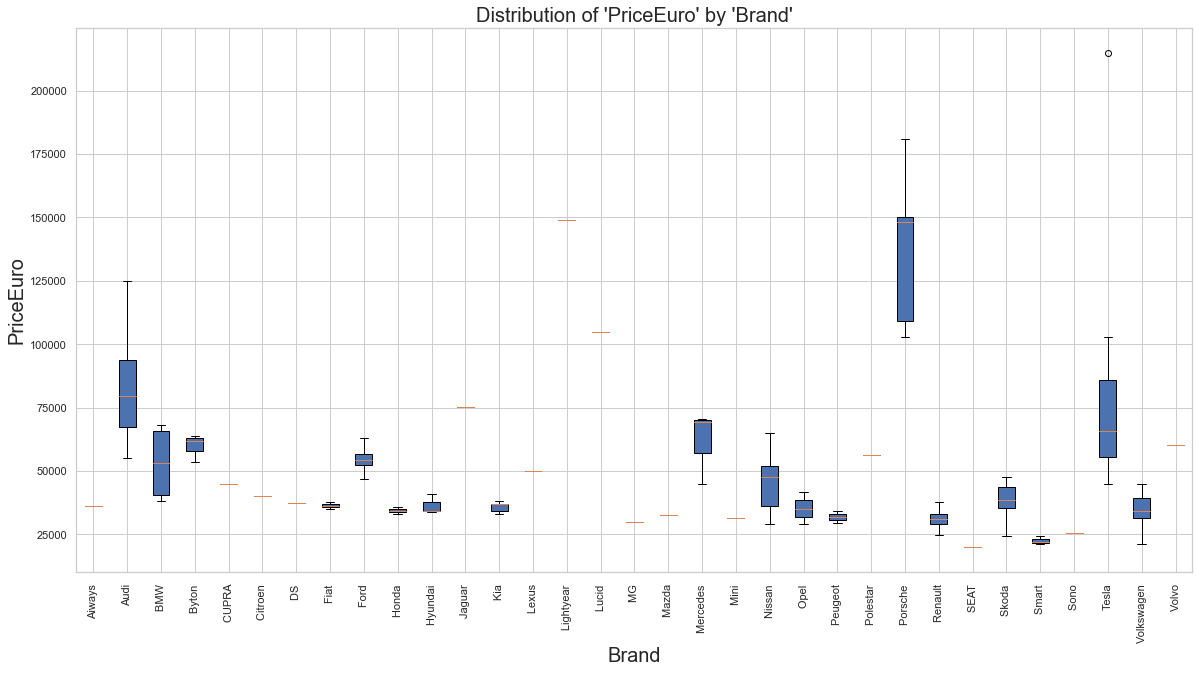

In [12]:
multiboxplot(evdata, 'PriceEuro', 'Brand', figsize=(20,10), rotation=90)

Excluding Tesla's outlier, Porsche and Audi look like they have the largest range in price available followed by Tesla. BMW and Nissan also stand out, but there are only half the brands that have multiple values so it's tough to evaluate manufacturers with only one model. Since there is such variation of prices across brands I don't expect there to be a strong relationship. In order to calculate the correlation we can use the `LabelEncoder()` from `sklearn.preprocessing`.

In [13]:
encoder = LabelEncoder()
evdata['Brand_encoded'] = encoder.fit_transform(evdata['Brand'])
measure_correlation(evdata['Brand_encoded'], price)

Correlation Statistics
----------------------
r   = -0.0360
rho = -0.1832


As expected there isn't much correlation between these two variables, but there is a slight negative relationship, though the non-linear relationship is stronger since `rho` > `r`.

## `Model` variable

Now we can take a look at the `Model` variable. Since we've seen some brands like Lightyear that make the most expensive vehicle on average, also only make one model which isn't very interesting. Since we know there are 33 distinct manufacturers let's see how many distinct models from the 103 observations.

In [14]:
print('Number of Distinct Models: ' + str(len(evdata['Model'].unique())))

Number of Distinct Models: 102


Well, it looks like this `Model` is no good ;) It won't do much good looking at the distribution but we may as well see which model has two prices. On a more serious note, I suspect this variable won't be very good to add to our model since it will likely cause some overfitting. Nonetheless, we can save that for the model evaluation.

In [15]:
descriptive_categorical(dataframe=evdata, col_name='Model', cmap1='gist_earth_r')

Model,% observations,Cumulative %
e_Soul 64 kWh,1.94%,1.94%
Kona Electric 64 kWh,0.97%,2.91%
iX3,0.97%,3.88%
e,0.97%,4.85%
Air,0.97%,5.83%
e_Golf,0.97%,6.80%
e_208,0.97%,7.77%
Model 3 Standard Range Plus,0.97%,8.74%
Q4 e_tron,0.97%,9.71%
EQC 400 4MATIC,0.97%,10.68%


## `Model` vs. `PriceEuro` pairwise variable compare

Since there is only unique value for model for all observations except 1, I don't think it will help much to do a scatterplot of `Model` and `PriceEuro` so we can just look at the correlation between the two. I don't expect there to be a high correlation, but definitely moreso than `Brand` because there are more discrete values. I think there will be a slight positive relationship since some models are definitely more expensive than others.

In [16]:
encoder = LabelEncoder()
evdata['Model_encoded'] = encoder.fit_transform(evdata['Model'])
measure_correlation(evdata['Model_encoded'], price)

Correlation Statistics
----------------------
r   = 0.1724
rho = 0.1128


## `AccelSec` single variable

The next variable is `AccelSec`, so while we go through the EDA process for this one we can also evaluate the next research question `3. Which car has the fastest 0-100 acceleration?`. But first let's look at the descriptive stats of this variable.

In [17]:
accel_col = evdata['AccelSec']
descriptive_numeric(evdata, 'AccelSec')

,AccelSec
Count,103.000000
Mean,7.396117
Std,3.017430
Min,2.100000
Q1,5.100000
Med,7.300000
Q3,9.000000
Max,22.400000
Range,20.300000
IQR,3.900000


It looks like some of these cars can accelerate pretty quickly with the fastest car going from 0-100km (0-62mph) is 2.1 seconds! With the `mean` and `median` being roughly equivalent this data doesn't seem it will be fairly normally distributed though with the `IQR` and `Std` being about the same, I suspect a pretty high peak around the mean but not too concentrated since the `COV` is 0.4. Let's take a look at the distribution plot to see how well the hypothesis holds up.

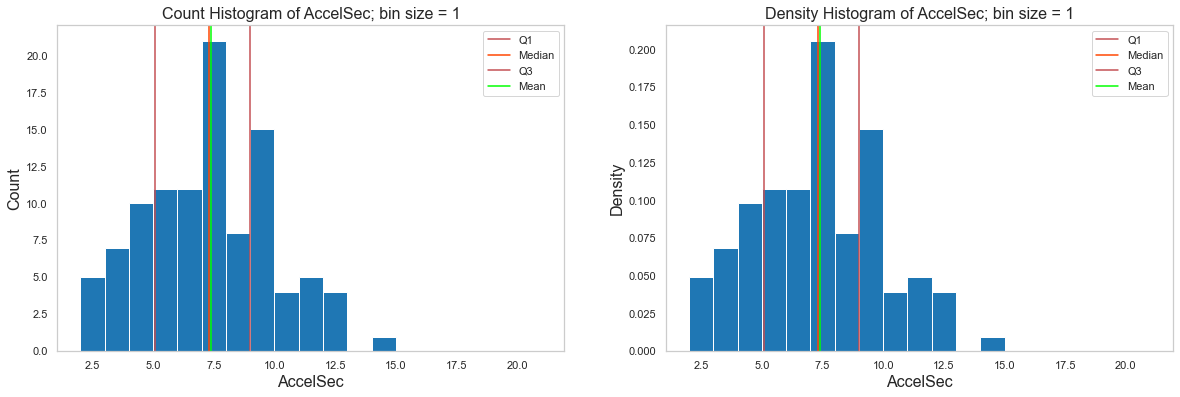

In [18]:
numeric_single_histogram(accel_col, 'AccelSec', autobin=True, plot_quantiles=True, color=plot_colors[0], 
                         quantile_colors=['r','orangered','r','lime'])

It looks like I was pretty close, there doesn't appear to be *too* much skewness but certainly one pretty slow car though I'd say a good amount are pretty quick. Since a smaller value for `AccelSec` means a car is faster, we should look at the left side of the distribution to answer our next research question:

<div style="background: darkturquoise; margin:20px; padding: 20px;">
        <b>Research Question:</b>
        <br> 3. Which car has the fastest 0-100 acceleration?
</div>

There are five cars that all have `AccelSec` values around 2.5 so let's query our `pandas` dataframe to see which models/brands have the quickest EVs.

In [19]:
accel_data = pd.DataFrame(evdata[['Brand','Model','AccelSec','PriceEuro']])
accel_data.sort_values(by='AccelSec', inplace=True)
accel_data

,Brand,Model,AccelSec,PriceEuro
51,Tesla,Roadster,2.1,215000
59,Tesla,Model S Performance,2.5,96990
81,Tesla,Model X Performance,2.8,102990
5,Lucid,Air,2.8,105000
16,Porsche,Taycan Turbo S,2.8,180781
...,...,...,...,...
43,Skoda,CITIGOe iV,12.3,24534
57,Renault,Twingo ZE,12.6,24790
77,Smart,EQ forfour,12.7,22030
66,Nissan,e_NV200 Evalia,14.0,33246


It looks like Tesla is really dominating all of these categories, however it certainly looks like their quicker cars are very pricey. The top 3 quickest cars are all Tesla models and average six figure price tags. Since these three models make up 25% of the Tesla inventory in this dataset I'd say their cars likely fall into the *luxury brand* category.

## `AccelSec` vs. `PriceEuro` pairwise variable compare

Next let's take a look at a pairwise comparison of `AccelSec` and `PriceEuro`. Since it looks like Teslas are the fastest, and also quite expensive I wonder what the correlation there is between these variables. Let's print out the descriptive statistics.

In [20]:
accel_stats = descriptive_numeric(evdata, 'AccelSec')
price_stats = descriptive_numeric(evdata, 'PriceEuro')
pd.concat([accel_stats, price_stats], axis=1)

,AccelSec,PriceEuro
Count,103.000000,103.000000
Mean,7.396117,55811.563107
Std,3.017430,34134.665280
Min,2.100000,20129.000000
Q1,5.100000,34429.500000
Med,7.300000,45000.000000
Q3,9.000000,65000.000000
Max,22.400000,215000.000000
Range,20.300000,194871.000000
IQR,3.900000,30570.500000


I suspect that the quicker the car accelerates, the more expensive it will be. Since a lower value of `AccelSec` indicates a faster acceleration, I think this variable will be negatively correlated with `PriceEuro`.

In [21]:
measure_correlation(accel_col, price)

Correlation Statistics
----------------------
r   = -0.6272
rho = -0.8383


Overall it looks like there is a fairly strong negative linear relationship between `AccelSec` and `PriceEuro` given that $r=-0.6272$, however with `rho`=-0.8383 it's likely there is a stronger non-linear relationship between these two variables.

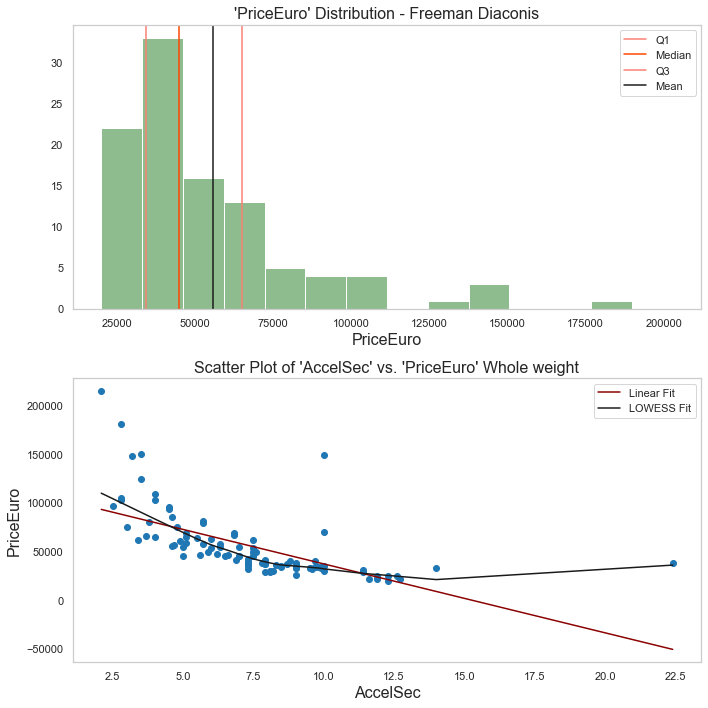

In [22]:
overlay_distro_and_scatter(evdata, 'AccelSec', 'PriceEuro', colors=['darkseagreen',plot_colors[0]], 
                         quantile_colors=['salmon','orangered','salmon','k'])

As expected, the LOWESS line is a much better fit than the Linear regression line, though it looks like some of the very expensive models by Tesla and Lightyear are potential outliers.

## `TopSpeed_KmH` single variable

The next variable is `TopSpeed_KmH` which is a nice segue from the last research question finding out which car has the fastest 0 - 100 accelearation. It will be interesting to see if some of the same cars with the fastest acceleration will also have the highest top speed.

In [23]:
top_speed_col = evdata['TopSpeed_KmH']
descriptive_numeric(evdata, 'TopSpeed_KmH')

,TopSpeed_KmH
Count,103.000000
Mean,179.194175
Std,43.573030
Min,123.000000
Q1,150.000000
Med,160.000000
Q3,200.000000
Max,410.000000
Range,287.000000
IQR,50.000000


I predict this distribution curve will have a tall peak around the median and a long right skewed tail. Based on a `COV` value of 0.24 the data will not be very spread out so this will be interesting to see plotted.

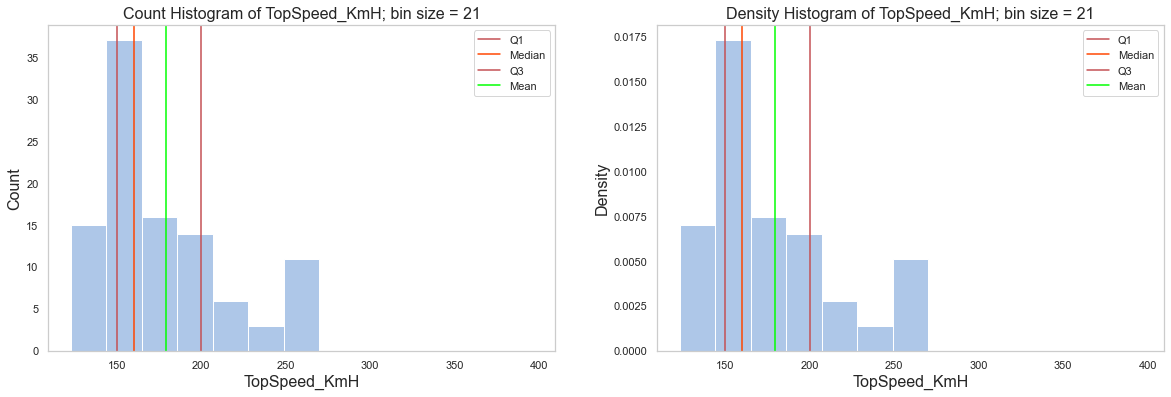

In [24]:
numeric_single_histogram(top_speed_col, 'TopSpeed_KmH', color=plot_colors[1], autobin=True, plot_quantiles=True, quantile_colors=['r','orangered','r','lime'])

The hypothesis was partially correct since the `Mean` is halfway between the `Median` and `Q3` causing some right skewedness, though instead of there being a long skinny tail, there is another peak around the max causing it. Additionally, I was correct with another large peak around the median but it also looks like Q1 is included in the same bin so fair amount of cars will have a top speed around 150 KmH.

## `TopSpeed_KmH` vs. `PriceEuro` pairwise variable compare

The `TopSpeed_KmH` distribution is similar to the `PriceEuro` distribution, however, the tails are the main difference since `TopSpeed_KmH` has a short and fat one whereas `PriceEuro` is long and skinny.

In [25]:
top_speed = descriptive_numeric(evdata, 'TopSpeed_KmH')
price_stats = descriptive_numeric(evdata, 'PriceEuro')
pd.concat([top_speed, price_stats], axis=1)

,TopSpeed_KmH,PriceEuro
Count,103.000000,103.000000
Mean,179.194175,55811.563107
Std,43.573030,34134.665280
Min,123.000000,20129.000000
Q1,150.000000,34429.500000
Med,160.000000,45000.000000
Q3,200.000000,65000.000000
Max,410.000000,215000.000000
Range,287.000000,194871.000000
IQR,50.000000,30570.500000


Looking at the difference in `COV` between both variables, there is certainly much less spread in `TopSpeed_KmH` than `PriceEuro` so. I don't think there will be a strong relationships between these variables. Nonetheless, I think the greater the `TopSpeed_KmH` is, the higher `PriceEuro` will be so I expect to see a positive correlation.

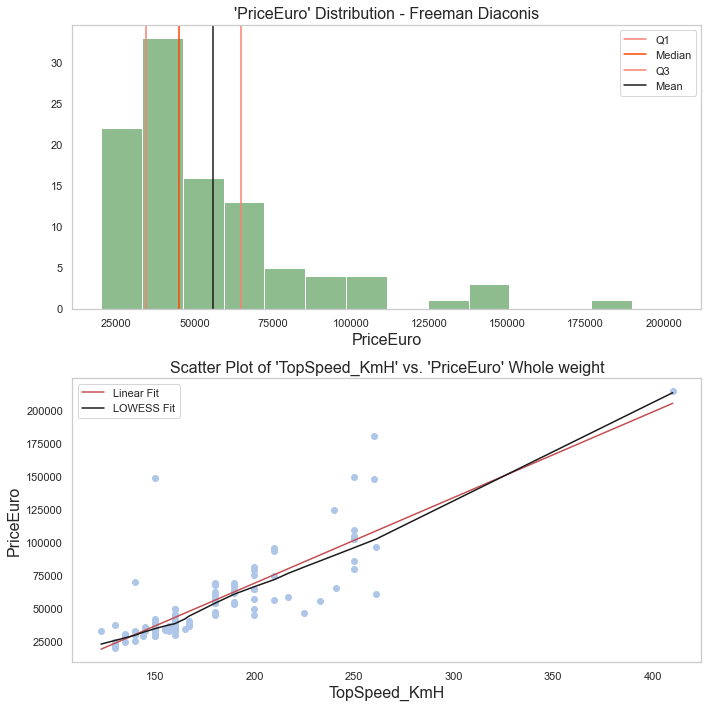

Correlation Statistics
----------------------
r   = 0.8291
rho = 0.8568


In [26]:
overlay_distro_and_scatter(evdata, 'TopSpeed_KmH', 'PriceEuro', colors=['darkseagreen', plot_colors[1]], 
                         quantile_colors=['salmon','orangered','salmon','k'], fit_colors=['r','k'])
measure_correlation(top_speed_col, price)

As predicted, there is a positive relationship between both variables but it's much stronger than expected. A majority of observations are below `TopSpeed_KmH` = 250 which helps strengthen the correlation. Additionally, both `r` and `rho` are greater than 0.80 so there is a very strong linear relationship between these variables, which will be good for building the Linear Regression model later on.

## `Range_Km` single variable

In my opinion this is the most interesting and valuable feature when picking out the *best* EV so it will be interesting to see it's relationship to price. Within the American market, it's common to see EV ranges of 200 - 300 miles which is 320 - 480 kilometers. Let's print out the descriptive stats of `Range_Km` to compare these expectations with the European market.

In [27]:
range_col = evdata['Range_Km']
descriptive_numeric(evdata, 'Range_Km')

,Range_Km
Count,103.000000
Mean,338.786408
Std,126.014444
Min,95.000000
Q1,250.000000
Med,340.000000
Q3,400.000000
Max,970.000000
Range,875.000000
IQR,150.000000


There is quite a large range for `Range_Km`; 875 km or 544 miles! However, It looks like the distribution is going to be fairly normal with a good concentration of data around the median sinced the `COV` = 0.37. I also suspect there will be a slight left skewedness to the distribution since the mean is slightly less than the median.

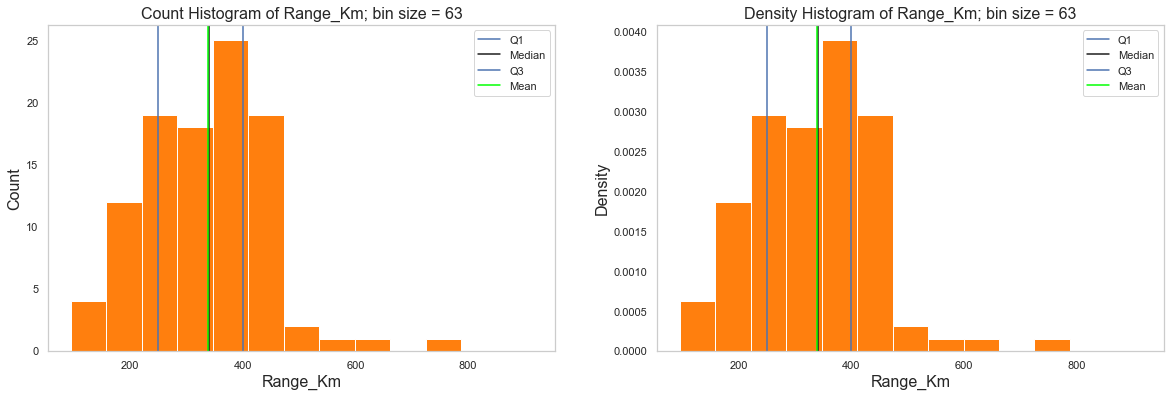

In [28]:
numeric_single_histogram(range_col, 'Range_Km', color=plot_colors[2], autobin=True, plot_quantiles=True, quantile_colors=['b','k','b','lime'])

As predicted, the distribution has a slight left skewedness, but the right tail drops off abruptly. The `Range_Km` distribution does not look very similar to the `PriceEuro` distribution so I'm not sure how well these variables will relate.

## `Range_Km` vs. `PriceEuro` pairwise variable compare

Next we can look at the pairwise comparison for both of these variables.

In [29]:
range_stats = descriptive_numeric(evdata, 'Range_Km')
price_stats = descriptive_numeric(evdata, 'PriceEuro')
pd.concat([range_stats, price_stats], axis=1)

,Range_Km,PriceEuro
Count,103.000000,103.000000
Mean,338.786408,55811.563107
Std,126.014444,34134.665280
Min,95.000000,20129.000000
Q1,250.000000,34429.500000
Med,340.000000,45000.000000
Q3,400.000000,65000.000000
Max,970.000000,215000.000000
Range,875.000000,194871.000000
IQR,150.000000,30570.500000


I suspect that there will be a positive relationship between these two variables; the longer the `Range_Km`, the more expensive the EV will be. Since the distributions of each individual variable aren't very similar I don't expect a higher correlation between both.

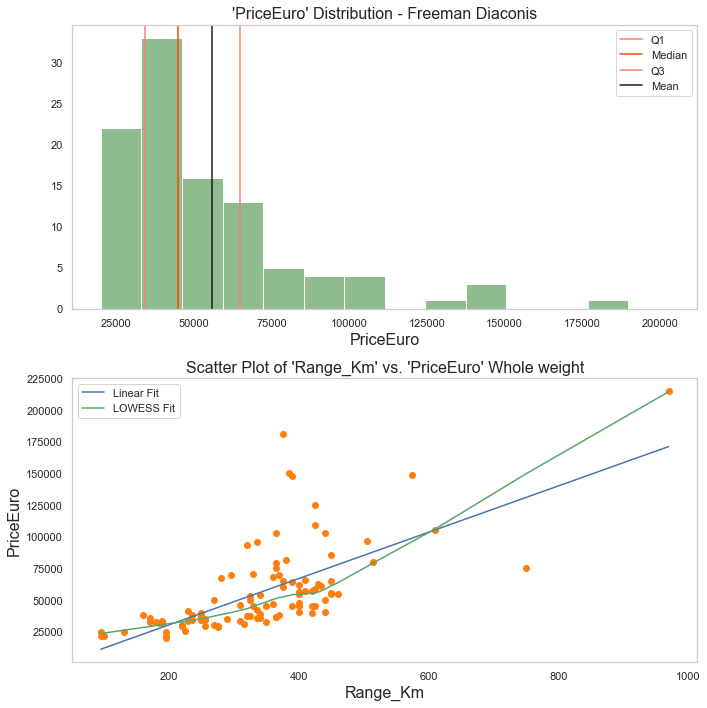

Correlation Statistics
----------------------
r   = 0.6748
rho = 0.7608


In [30]:
overlay_distro_and_scatter(evdata, 'Range_Km', 'PriceEuro', colors=['darkseagreen',plot_colors[2]], 
                         quantile_colors=['salmon','orangered','salmon','k'], fit_colors=['b','g'])
measure_correlation(range_col, price)

Interestingly enough, some of the "mid range" cars are quite expensive which I expect fall into the *luxury brand* category. Excluding those it's possible to see a better relationship between `Range_Km` and `PriceEuro` which I suspose is why `rho` > `r` as there is a stronger non-linear relationship than a linear one.

## `Efficiency_WhKm` single variable

This variable is efficiency of the EV in terms of Watt Hours used per Kilometer, hence the abbreviated field name `Efficiency_WhKm`. Therefore, the lower the value, the more efficient the vehicle is.

In [31]:
efficiency_col = evdata['Efficiency_WhKm']
descriptive_numeric(evdata, 'Efficiency_WhKm')

,Efficiency_WhKm
Count,103.000000
Mean,189.165049
Std,29.566839
Min,104.000000
Q1,168.000000
Med,180.000000
Q3,203.000000
Max,273.000000
Range,169.000000
IQR,35.000000


This variable appears as though it has the lowest amount of spread (i.e. - highly concentrated) close the median based on the `COV` = 0.156. Additionally, the `IQR` is quite small and similar value as the `Std` which is another indication that the data will be concentrated.

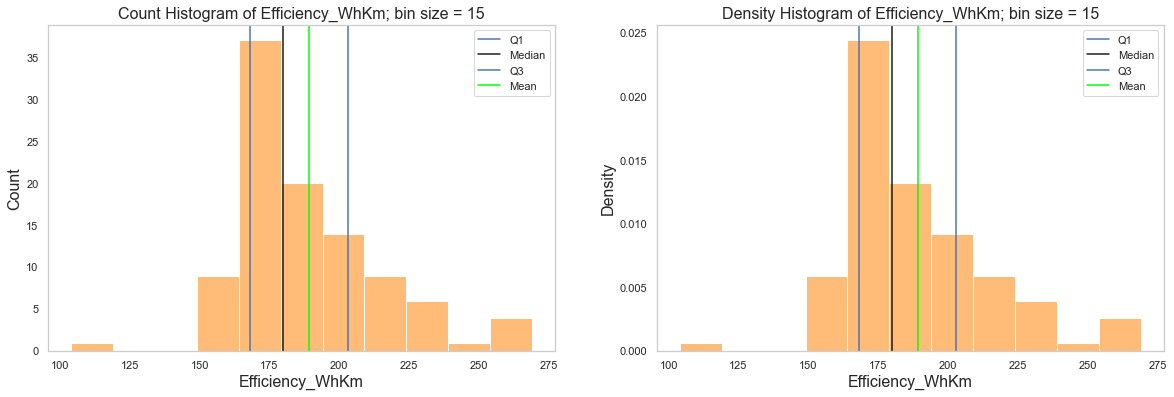

In [32]:
numeric_single_histogram(efficiency_col, 'Efficiency_WhKm', color=plot_colors[3], autobin=True, plot_quantiles=True, quantile_colors=['b','k','b','lime'])

Interesting. This is slightly more normal than I expected, though there is some right skewedness, there also appears to be an outlier at the left side of the distribution, especially since no other bins connect to it. However, before we analyze at the pairwise comparison let's answer the next research question.

<div style="background: darkturquoise; margin:20px; padding: 20px;">
        <b>Research Question:</b>
        <br> 4. Which has the highest efficiency?
</div>

In [33]:
efficiency_data = pd.DataFrame(evdata[['Brand', 'Model', 'Efficiency_WhKm', 'PriceEuro']])
efficiency_data.sort_values(by='Efficiency_WhKm', ascending=True, inplace=True)
efficiency_data

,Brand,Model,Efficiency_WhKm,PriceEuro
48,Lightyear,One,104,149000
8,Tesla,Model 3 Standard Range Plus,153,46380
14,Hyundai,IONIQ Electric,153,34459
41,Hyundai,Kona Electric 39 kWh,154,33971
74,Sono,Sion,156,25500
...,...,...,...,...
99,Audi,e_tron S Sportback 55 quattro,258,96050
67,Tesla,Cybertruck Dual Motor,261,55000
33,Tesla,Cybertruck Tri Motor,267,75000
90,Audi,e_tron S 55 quattro,270,93800


Lightyear makes the most efficient EV in terms of WhKm, however it's extremely expensive. In fact, it's one of the most expensive vehicles as found out in the `PriceEuro` variable analysis. Nonetheless, the next most efficient vehicles are much more reasonably priced. Based on the `head` and `tail` of the dataframe it looks like the prices a little inconsistent so I don't expect a strong relationship between `Efficiency_WhKm` and `PriceEuro`.

## `Efficiency_WhKm` vs. `PriceEuro` pairwise variable compare

In [34]:
efficiency_stats = descriptive_numeric(evdata, 'Efficiency_WhKm')
price_stats = descriptive_numeric(evdata, 'PriceEuro')
pd.concat([efficiency_stats, price_stats], axis=1)

,Efficiency_WhKm,PriceEuro
Count,103.000000,103.000000
Mean,189.165049,55811.563107
Std,29.566839,34134.665280
Min,104.000000,20129.000000
Q1,168.000000,34429.500000
Med,180.000000,45000.000000
Q3,203.000000,65000.000000
Max,273.000000,215000.000000
Range,169.000000,194871.000000
IQR,35.000000,30570.500000


As mentioned, I don't expect there to be a strong relationship between these variables after answering the last research question. Looking at the descriptive stats of both variables, while keeping in mind the results of the single varible distribution, they don't appear to be very similar with especially `COV` values differing by 0.46.

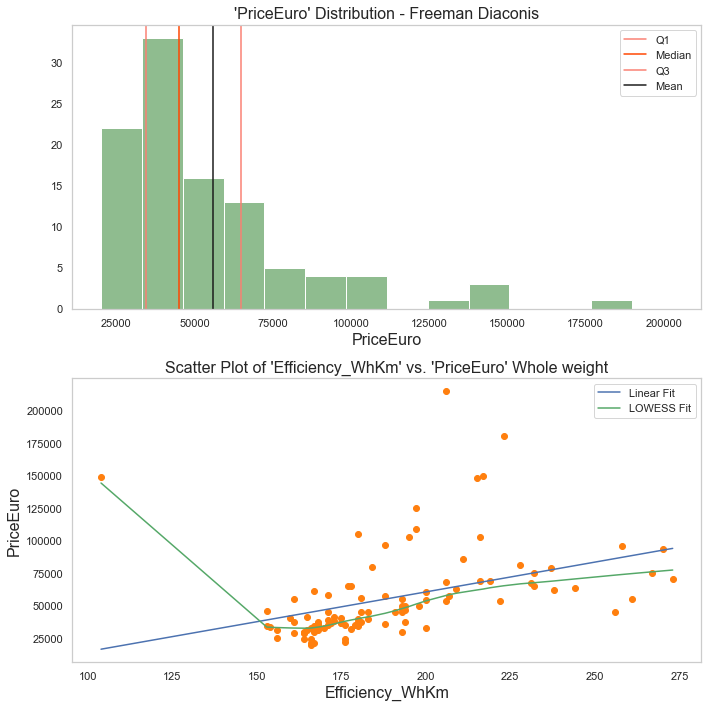

Correlation Statistics
----------------------
r   = 0.3967
rho = 0.6877


In [35]:
overlay_distro_and_scatter(evdata, 'Efficiency_WhKm', 'PriceEuro', colors=['darkseagreen',plot_colors[2]], 
                         quantile_colors=['salmon','orangered','salmon','k'], fit_colors=['b','g'])
measure_correlation(efficiency_col, price)

Interestingly enough, there is not a very strong linear relationship between these two variables though there appears to be a strong non-linear relationship since `rho` > `r`.

## `FastCharge_KmH` single variable

The next variable is `FastCharge_KmH`, also referred to as the "Charging speed...how many km or miles are added to the range during charging per hour" per [engineeringtoolbox.com](https://www.engineeringtoolbox.com/ev-electrical-vehicle-power-supply-charging-speed-d_2154.html). So the higher the value, the more 'efficient' the EV is at being charged. 

In [36]:
descriptive_numeric(evdata, 'FastCharge_KmH')

,FastCharge_KmH
Count,98.000000
Mean,456.734694
Std,201.262897
Min,170.000000
Q1,275.000000
Med,440.000000
Q3,560.000000
Max,940.000000
Range,770.000000
IQR,285.000000


Something to keep in mind is that when the `FastCharge_KmH` field was "cleaned" during the **GET** step, it needed to be converted from a string to a number and I replaced the `-` values with `None` so it would not impact the distributions of this variable. Therefore there are only 98 values for the 103 observations. Based on the `mean` > `Med`, I expect there to be some skewness to the data. However, the `Range` is quite large but there will be a fair amount of spread since `COV` = 0.44.

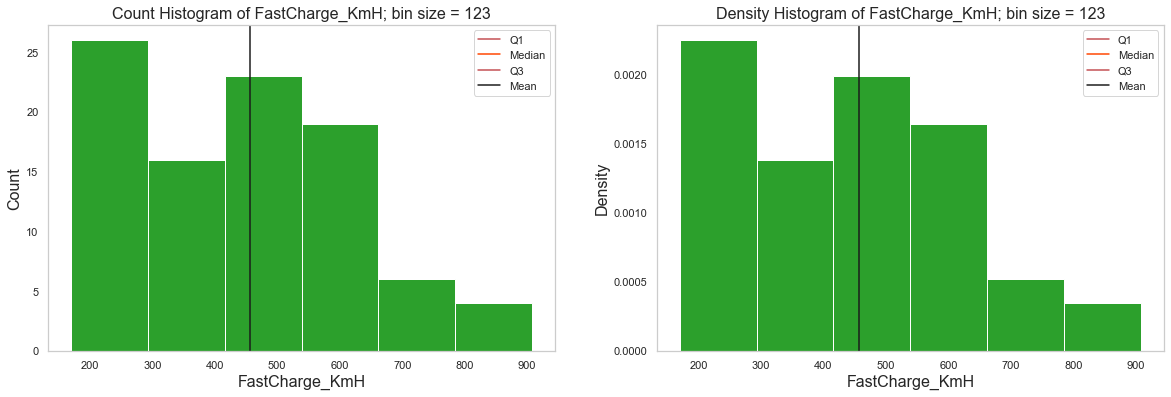

In [37]:
numeric_single_histogram(evdata['FastCharge_KmH'], 'FastCharge_KmH', autobin=True, plot_quantiles=True, color=plot_colors[4], 
                         quantile_colors=['r','orangered','r','k'])

## `FastCharge_KmH` vs. `PriceEuro` pairwise variable compare

I expect there to be a positive relationship between both variables so the higher the value of `FastCharge_KmH`, the more expensive the vehicle.

In [38]:
charge_stats = descriptive_numeric(evdata, 'FastCharge_KmH')
price_stats = descriptive_numeric(evdata, 'PriceEuro')
pd.concat([charge_stats, price_stats], axis=1)

,FastCharge_KmH,PriceEuro
Count,98.000000,103.000000
Mean,456.734694,55811.563107
Std,201.262897,34134.665280
Min,170.000000,20129.000000
Q1,275.000000,34429.500000
Med,440.000000,45000.000000
Q3,560.000000,65000.000000
Max,940.000000,215000.000000
Range,770.000000,194871.000000
IQR,285.000000,30570.500000


I think that there will be a positive relationship between `FastCharge_KmH` and `PriceEuro`. As mentioned in the **GET** section, to properly handle the scatter plot with fitted lines and calculating the correlation, I will remove the records with `None` values for `FastCharge_KmH`.

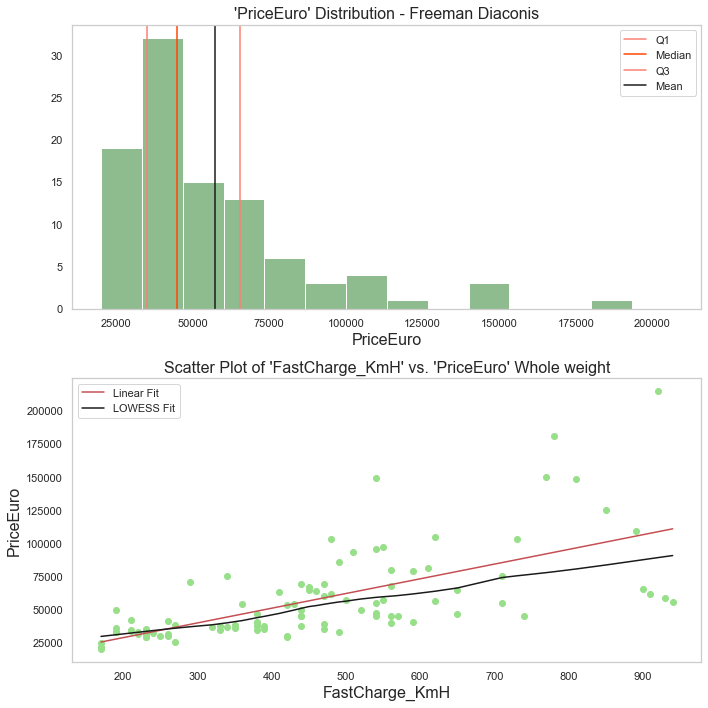

Correlation Statistics
----------------------
r   = 0.6516
rho = 0.7489


In [39]:
charge_evdata = pd.DataFrame(evdata.dropna())
overlay_distro_and_scatter(charge_evdata, 'FastCharge_KmH', 'PriceEuro', colors=['darkseagreen', plot_colors[5]], 
                         quantile_colors=['salmon','orangered','salmon','k'], fit_colors=['r','k'])
measure_correlation(charge_evdata['FastCharge_KmH'], charge_evdata['PriceEuro'])

There appears to be a moderately strong relationship positive relationship between `FastCharge_KmH` and `PriceEuro` though the non-linear relationship looks like a better fit than the linear one.

## `RapidCharge` single variable

This variable relates to the prior one, `RapidCharge_KmH`, in which 5 of the observations did not apply. Since this is a boolean field it will not be too interesting to look at since 98 observations are `yes` and 5 are `no`.

In [40]:
rapid_charge = evdata['RapidCharge']
descriptive_categorical(dataframe=evdata, col_name='RapidCharge', cmap1='gist_earth_r')

RapidCharge,% observations,Cumulative %
Yes,95.15%,95.15%
No,4.85%,100.00%


## `RapidCharge` vs. `PriceEuro` pairwise variable compare

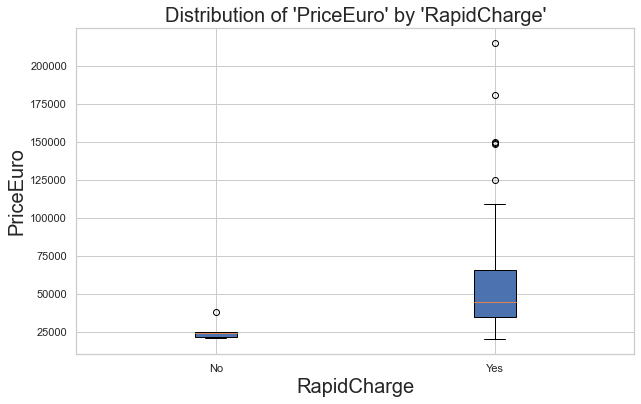

In [41]:
multiboxplot(evdata, 'PriceEuro', 'RapidCharge', figsize=(10,6))

Unsurprisingly, there are a lot more observations in the `Yes` bin and it has a much wider range than the `No` bin so I suspect the EVs without rapid charge are less expensive so I think it will have somewhat of a relationship with `PriceEuro`. To look at the correlation between `PriceEuro` and `RapidCharge` we can encode `RapidCharge` since it's categorical.

In [42]:
encoder = LabelEncoder()
evdata['RapidCharge_encoded'] = encoder.fit_transform(evdata['RapidCharge'])
measure_correlation(evdata['RapidCharge_encoded'], price)

Correlation Statistics
----------------------
r   = 0.1972
rho = 0.3054


I did not expect there to be such a weak relationship between these two variables, though since `rho` > `r` it looks like there is a stronger non-linear relationship albeit still not a strong one.

## `PowerTrain` single variable

Next we can look at the `PowerTrain` which has 3 different values, `AWD`, `RWD` and `FWD` similar to internal combustion engine (ICE) vehicles.

In [43]:
power_train = evdata['PowerTrain']
descriptive_categorical(dataframe=evdata, col_name='PowerTrain', cmap1='gist_earth_r')

PowerTrain,% observations,Cumulative %
AWD,39.81%,39.81%
FWD,35.92%,75.73%
RWD,24.27%,100.00%


There is a fairly unimodal distribution between the different `PowerTrain` values but it looks about 3/4 of the vehicles, with a fairly even split, are either `AWD` or `FWD` EVs, but less than a quarter are `RWD`.

## `PowerTrain` vs. `PriceEuro` pairwise variable compare

Next we can compare both variables. I think that `PowerTrain` = `AWD` will be the most expensive since it requires dual motors but I'm curious to see how the correlation between these variables turns out.

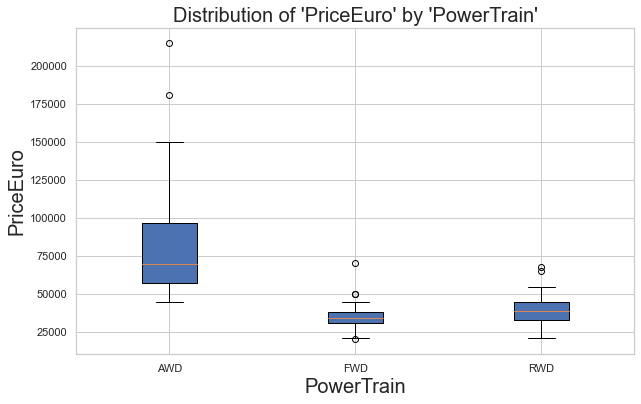

In [44]:
multiboxplot(evdata, 'PriceEuro', 'PowerTrain', figsize=(10,6))

Interestingly enough it looks like the `FWD` and `RWD` vehicles are similar in price rainge, but overall less expensive than the `AWD` vehicles. Next we can encode the variables and see how strong of a relationship each has to `PriceEuro`.

In [45]:
encoder = LabelEncoder()
evdata['PowerTrain_encoded'] = encoder.fit_transform(evdata['PowerTrain'])
measure_correlation(evdata['PowerTrain_encoded'], price)

Correlation Statistics
----------------------
r   = -0.5616
rho = -0.6596


It looks like there is a fairly strong negative relationship between `PowerTrain` and `PriceEuro`, but since the value of `rho` is closer to -1 than `r` there is more of a non-linear relationship than a linear one. Now we can look at our next research question comparing `PowerTrain` to `Range_Km`, `TopSpeed_KmH`, and `Efficiency_WhKm`.

<div style="background: darkturquoise; margin:20px; padding: 20px;">
        <b>Research Question:</b>
        <br> 5. Does a difference in power train effect the range, top speed, efficiency?

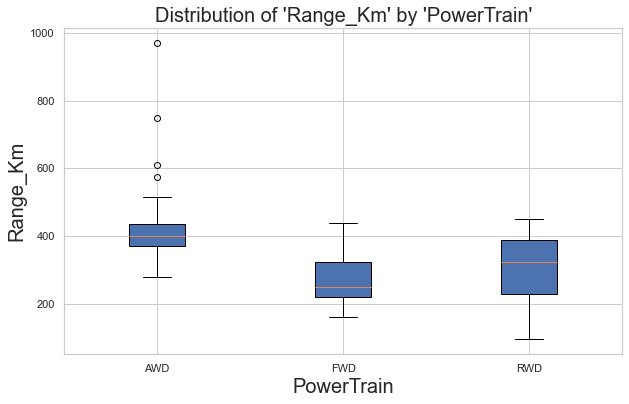

Correlation Statistics
----------------------
r   = -0.4515
rho = -0.4908


In [46]:
multiboxplot(evdata, 'Range_Km', 'PowerTrain', figsize=(10,6))
measure_correlation(evdata['PowerTrain_encoded'], evdata['Range_Km'])

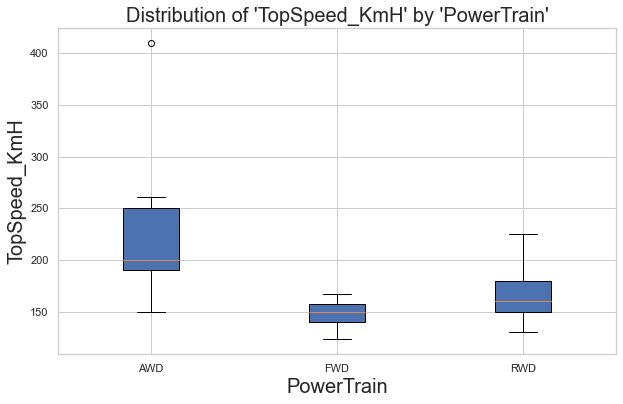

Correlation Statistics
----------------------
r   = -0.5605
rho = -0.6131


In [47]:
multiboxplot(evdata, 'TopSpeed_KmH', 'PowerTrain', figsize=(10,6))
measure_correlation(evdata['PowerTrain_encoded'], evdata['TopSpeed_KmH'])

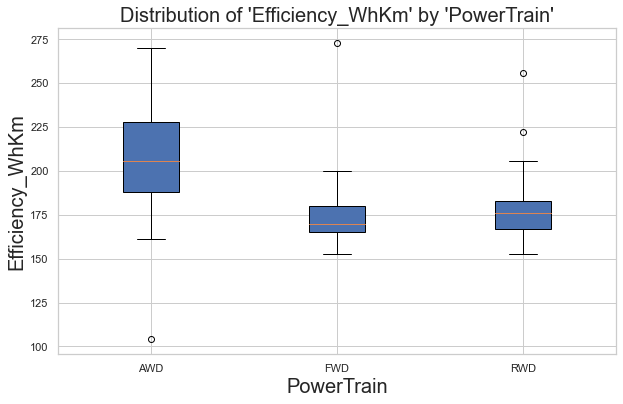

Correlation Statistics
----------------------
r   = -0.3947
rho = -0.4632


In [48]:
multiboxplot(evdata, 'Efficiency_WhKm', 'PowerTrain', figsize=(10,6))
measure_correlation(evdata['PowerTrain_encoded'], evdata['Efficiency_WhKm'])

Overall, there is somewhat of a relationship between `PowerTrain` and `Range_Km`, `TopSpeed_KmH`, and `Efficiency_WhKm`, however they aren't particularly strong. The highest $R^2$ value is for between `PowerTrain` and `TopSpeed_KmH` which is -0.56. Looking at the boxplot for these variables makes it seem like AWD EVs are overall faster than RWD and FWD. Within this sample, FWD cars seem to be the slowest.

For `Range_Km`, it looks like AWD EVs have consistently higher values than FWD/RWD EVs. However, for `Efficiency_WhKm` there doesn't appear to be a large difference between `PowerTrain` variations. Though AWD vehicles has the most efficient car, overall FWD and RWD seem to be more efficient on average. Nonetheless, I think it makes sense that `PowerTrain` has the least impact on this variable.

## `PlugType` single variable

Next we are going to look at the different `PlugType` options available for these EVs. There are different plug types based on region and current (AC or DC) - below is an image of what the different plug types look like. 

<img src="ev_charge_plugs.png" alt="ev_plugs" width="400"/>

**Image Source:** [https://www.evexpert.eu/eshop1/knowledge-center/connector-types-for-ev-charging-around-the-world](https://www.evexpert.eu/eshop1/knowledge-center/connector-types-for-ev-charging-around-the-world)

In [49]:
rapid_charge = evdata['PlugType']
descriptive_categorical(dataframe=evdata, col_name='PlugType', cmap1='gist_earth_r')

PlugType,% observations,Cumulative %
Type 2 CCS,87.38%,87.38%
Type 2,8.74%,96.12%
Type 2 CHAdeMO,2.91%,99.03%
Type 1 CHAdeMO,0.97%,100.00%


It looks like a majority of the EVs use the Type 2 plug, with 87.38% using the DC version and 8.74% using the AC version. The remaining vehicles use CHAdeMO type plugs. 

## `PlugType` vs. `PriceEuro` pairwise variable compare

Based on the single variable distribution of `PlugType` it's difficult to say what sort or relationship, if any, it will have with `PriceEuro`. Since it looks like the plug types are really just based on Region, I think this variable will have a very weak relationship with price. Instead of a positive/negative relationship, I expect to see more of a monotonic one between these two variables.

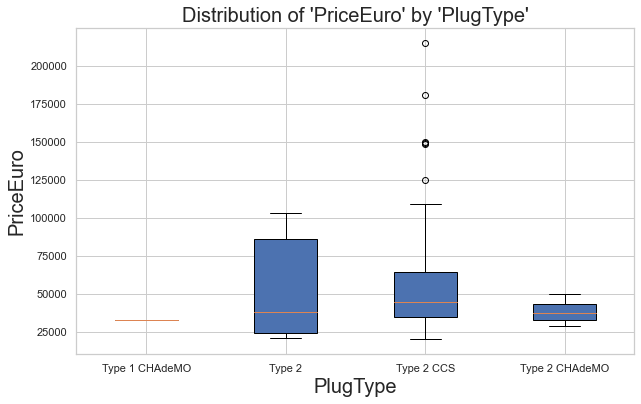

In [50]:
multiboxplot(evdata, 'PriceEuro', 'PlugType', figsize=(10,6))

Unfortunately this boxplot isn't really telling us much. Since most of the EVs have `Type 2` and `Type 2 CCS` plugs it makes sense they have the most variability within their distributions. In order to see if there is any correlation between these variables we can encode `PlugType`.

In [51]:
encoder = LabelEncoder()
evdata['PlugType_encoded'] = encoder.fit_transform(evdata['PlugType'])
measure_correlation(evdata['PlugType_encoded'], price)

Correlation Statistics
----------------------
r   = -0.0002
rho = 0.0268


As expected, there isn't a very strong relationship between `PlugType` and `PriceEuro` so this will definitely be something to consider in the model building step. Perhaps we may want to exclude this one in the final model.

## `BodyStyle` single variable

The `BodyStyle` variable tells us what "type" of EV each observation it is. We'll see some familiar body types used to describe ICE vehicles like SUV, Hatchback, Sedan, Pickup, etc.

In [52]:
bodystyle = evdata['BodyStyle']
descriptive_categorical(dataframe=evdata, col_name='BodyStyle', cmap1='gist_earth_r')

BodyStyle,% observations,Cumulative %
SUV,43.69%,43.69%
Hatchback,31.07%,74.76%
Sedan,9.71%,84.47%
Liftback,4.85%,89.32%
Pickup,2.91%,92.23%
Cabrio,2.91%,95.15%
SPV,2.91%,98.06%
MPV,0.97%,99.03%
Station,0.97%,100.00%


A majority of the EVs are going to be either an SUV, Hatchback, or Sedan since those make up almost 85% of observations. I think SUVs will certainly be more expensive than Hatchbacks and Sedans. Similarly, I also think the Pickup will be more expensive than those two body styles.

## `BodyStyle` vs. `PriceEuro` pairwise variable compare

Based on the distribution of `BodyStyle` I expect to see a slight positive relationship between this variable and `PriceEuro`. However, let's first take a look at the boxplot with both variables.

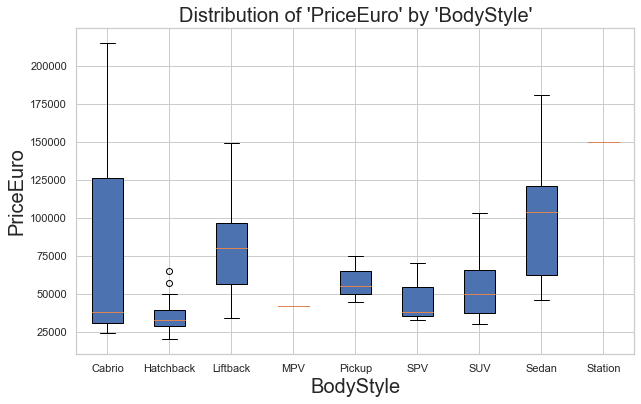

In [53]:
multiboxplot(evdata, 'PriceEuro', 'BodyStyle', figsize=(10,6))

Interestingly enough, it looks like the Cabrio style has the most variability and SUVs are not as expensive as I thought since most Sedans cost more. I'm not entirely sure what to expect for the correlation between these two variables but I don't think it will be very strong because a lot of the boxplots overlap.

In [54]:
encoder = LabelEncoder()
evdata['BodyStyle_encoded'] = encoder.fit_transform(evdata['BodyStyle'])
measure_correlation(evdata['BodyStyle_encoded'], price)

Correlation Statistics
----------------------
r   = 0.3217
rho = 0.5464


There is somewhat of a positive relationship between these two variables though it's not too strong. Again, `rho` > `r` so there is a stronger non-linear relationship than a linear one.

## `Segment` single variable

The next variable, `Segment` is similar to `BodyStyle` in that it's used to describe relatively how large the vehicle is, so it's used to segment the different BodyStyles. For instance, the Tesla Model 3 is a Sedan `BodyStyle` but it is classified as `Segment` D (Large).

In [55]:
segment = evdata['Segment']
descriptive_categorical(dataframe=evdata, col_name='Segment', cmap1='gist_earth_r')

Segment,% observations,Cumulative %
C,29.13%,29.13%
B,21.36%,50.49%
D,14.56%,65.05%
F,11.65%,76.70%
E,9.71%,86.41%
A,6.80%,93.20%
N,5.83%,99.03%
S,0.97%,100.00%


This distribution isn't quite uniform or normal. There are 8 unique segments and 4 of them account for over 75% of observations.

## `Segment` vs. `PriceEuro` pairwise variable compare

I suspect there will be somewhat of a positive relationship between `Segment` and `PriceEuro`, though I don't expect there to be a strong relationship. Instead, I think it would be good to combine `Segment` and `BodyStyle` when building a model to see if these two variables can be used to create one with a stronger relationship to `PriceEuro`.

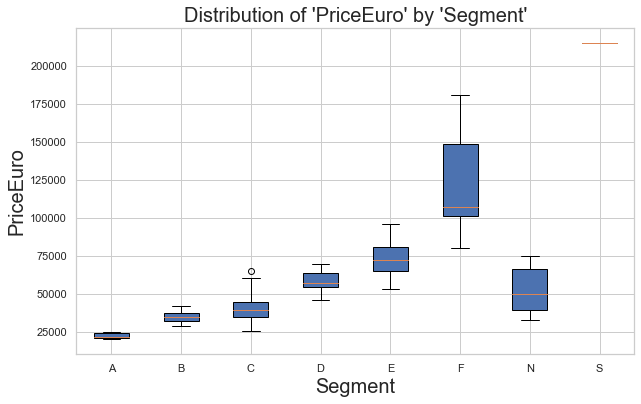

In [56]:
multiboxplot(evdata, 'PriceEuro', 'Segment', figsize=(10,6))

*Very* Interesting. It looks like the larger the letter, the more expensive the vehicle, with the exception of Segment N and S. Based on these boxplots I think there will be a fairly strong relationship between `PriceEuro` and `Segment` so let's encode the categorical variable and then calculate the correlation.

In [57]:
encoder = LabelEncoder()
evdata['Segment_encoded'] = encoder.fit_transform(evdata['Segment'])
measure_correlation(evdata['Segment_encoded'], price)

Correlation Statistics
----------------------
r   = 0.7371
rho = 0.8248


Very nice, there is a pretty strong positive relationship between these two variables so it will definitely be good to see how `BodyStyle` and `Segment` work together in the regression model. 

## `Seats` single variable

The final variable we will look at is `Seats` which is pretty self explanatory. It's my assumption that the more seats there are in a vehicle, the larger it will be, hence it will be more expensive so I am going to predict the same for these EVs. The more seats there are, the more expensive the EV. First let's take a look at the distribution of seat count.

In [58]:
seats = evdata['Seats']
descriptive_categorical(dataframe=evdata, col_name='Seats', cmap1='gist_earth_r')

Seats,% observations,Cumulative %
5,68.93%,68.93%
4,20.39%,89.32%
7,5.83%,95.15%
6,2.91%,98.06%
2,1.94%,100.00%


So it looks like the majority of vehicles have the standard 5 seats with some having only 4. Nonetheless, cars with 4 or 5 seats account for almost 90% of observations so I don't think there will be a strong relationship between `Seats` and `PriceEuro`.

## `Seats` vs. `PriceEuro` pairwise variable compare

Before calcualting the correlation between these variables let's create boxplots to see how well the initial hypothesis holds up - no real relationship between the two variables.

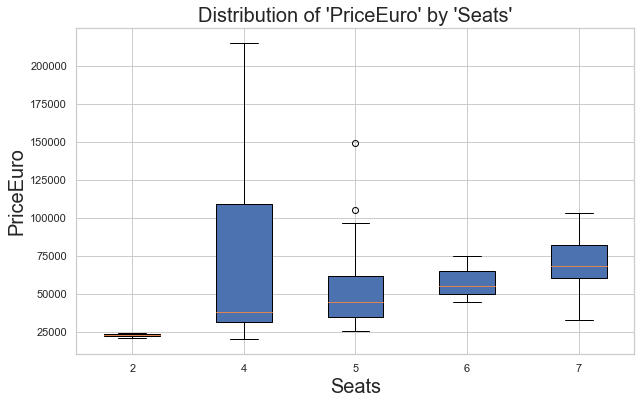

In [59]:
multiboxplot(evdata, 'PriceEuro', 'Seats', figsize=(10,6))

It looks like there would be a pretty strong positive relationship between number of seats and price if it weren't for the extremely wide distribution of 4 seat models. With that being said, I think there be a positive relationship between `Seats` and `PriceEuro` but don't expect a very strong one. So let's encode `Seats` and calculate the correlation.

In [60]:
encoder = LabelEncoder()
evdata['Seats_encoded'] = encoder.fit_transform(evdata['Seats'])
measure_correlation(evdata['Seats_encoded'], price)

Correlation Statistics
----------------------
r   = -0.0030
rho = 0.2050


Based on the `r` value there *is* almost no relationship between the two variables. However, if we consider `rho` then there is a fairly weak positive non-linear relationship, which is definitely something to keep in mind when building the model.

<div style="background: darkturquoise; margin:20px; padding: 20px;">
        <b>Research Question:</b>
        <br> 6. Which factors (efficiency, rapid charge, range, brand, etc.) have the most influence on price?
</div>


In [61]:
def correlations(data, y, xs):
    rs = []
    rhos = []
    for x in xs:
        r = stats.pearsonr(data[y], data[x])[0]
        rs.append(r)
        rho = stats.spearmanr(data[y], data[x])[0]
        rhos.append(rho)
    return pd.DataFrame({"feature": xs, "r": rs, "rho": rhos})

evdata_encoded = pd.read_csv('evdata/ElectricCarData_Clean.csv')
encoder = LabelEncoder()
evdata_encoded['Seats'] = encoder.fit_transform(evdata_encoded['Seats'])
evdata_encoded['Segment'] = encoder.fit_transform(evdata_encoded['Segment'])
evdata_encoded['Brand'] = encoder.fit_transform(evdata_encoded['Brand'])
evdata_encoded['Model'] = encoder.fit_transform(evdata_encoded['Model'])
evdata_encoded['PowerTrain'] = encoder.fit_transform(evdata_encoded['PowerTrain'])
evdata_encoded['PlugType'] = encoder.fit_transform(evdata_encoded['PlugType'])
evdata_encoded['RapidCharge'] = encoder.fit_transform(evdata_encoded['RapidCharge'])
evdata_encoded['BodyStyle'] = encoder.fit_transform(evdata_encoded['BodyStyle'])
evdata_encoded['FastCharge_KmH'].mask(evdata_encoded['FastCharge_KmH']=='-', '0', inplace=True)
evdata_encoded['FastCharge_KmH'] = pd.to_numeric(evdata_encoded['FastCharge_KmH'])
correlations(evdata_encoded, 'PriceEuro', ['Brand', 'Model', 'AccelSec', 'TopSpeed_KmH', 'Range_Km',
                                        'Efficiency_WhKm', 'FastCharge_KmH', 'RapidCharge', 'PowerTrain',
                                        'PlugType', 'BodyStyle', 'Segment', 'Seats'])

,feature,r,rho
0,Brand,-0.036023,-0.183175
1,Model,0.172401,0.112769
2,AccelSec,-0.627174,-0.838277
3,TopSpeed_KmH,0.829057,0.856850
4,Range_Km,0.674844,0.760840
5,Efficiency_WhKm,0.396705,0.687652
6,FastCharge_KmH,0.658882,0.773474
7,RapidCharge,0.197208,0.305442
8,PowerTrain,-0.561584,-0.659622
9,PlugType,-0.000193,0.026819


Based on the `correlations()` function, it looks like `TopSpeed_KmH`, `AccelSec`, `Segment`, `FastCharge_KmH`, and `Range_Km` have the strongest relationship with `PriceEuro`. Therefore, these features have the most influence on price.

# **MODEL**

First we will start by encoding all the categorical variables so they can be used in the regression models.

## 1. Null Model

In [62]:
evdata = pd.read_csv('evdata/ElectricCarData_Clean.csv')

# features of the model
numeric_features = ['PriceEuro', 'AccelSec', 'TopSpeed_KmH', 'Range_Km'
                    , 'Efficiency_WhKm', 'FastCharge_KmH']
categorical_features = ['Brand', 'Model', 'RapidCharge', 'PowerTrain', 'PlugType'
                        , 'BodyStyle', 'Segment', 'Seats']


# select numeric features from the dataframe
evmodel_data = pd.DataFrame(evdata[numeric_features])
evmodel_data['FastCharge_KmH'].mask(evmodel_data['FastCharge_KmH']=='-', '0', inplace=True)
evmodel_data['FastCharge_KmH'] = pd.to_numeric(evmodel_data['FastCharge_KmH'])

# removing all spaces so one hot encoding will work with regression modeling
evdata = evdata.replace(' ','_', regex=True)

# encode all the categorical features from the dataframe
for feature in categorical_features:
    evmodel_data = pd.concat([evmodel_data, pd.get_dummies(evdata[feature], prefix=feature)], axis=1)

# display data to make sure transformations were done correctly
nullmodel_data = pd.DataFrame(evmodel_data)
nullmodel_data.head()

,PriceEuro,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,Brand_Aiways_,Brand_Audi_,Brand_BMW_,Brand_Byton_,...,Segment_D,Segment_E,Segment_F,Segment_N,Segment_S,Seats_2,Seats_4,Seats_5,Seats_6,Seats_7
0,55480,4.6,233,450,161,940,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,30000,10.0,160,270,167,250,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,56440,4.7,210,400,181,620,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,68040,6.8,180,360,206,560,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,32997,9.5,145,170,168,190,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
def contains_digit(string):
    for char in string:
        if char.isdigit():
            return True
        return False
    
nullmodel_formula = "PriceEuro ~ "
features = nullmodel_data.loc[:, nullmodel_data.columns != 'PriceEuro'].columns

for i, feature in enumerate(features):
    if i == len(features) - 1:
        nullmodel_formula += feature
    else:
        nullmodel_formula += feature + " + "

null_result = models.bootstrap_linear_regression(nullmodel_formula, data=nullmodel_data)
models.describe_bootstrap_lr(null_result)

There seems to be something strange going on with this model, especially since the upper/lower bounds of $R^2$ is 1.00, and $\sigma$ is NaN. Let's look at the residual plots to see if there is anything strang going on.

In [ ]:
def plot_residuals(result, data, variables, return_values=False):
    figure = plt.figure(figsize=(15,10))


    plots = len(variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(data[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals", fontsize=16)
        axes.set_title(variable, fontsize=16)
    if return_values:
        return residuals
    else:
        plt.tight_layout()
        plt.show()
        plt.close()

In [ ]:
plot_residuals(null_result, evmodel_data, ['AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm', 'FastCharge_KmH'])

So it looks like this null model is highly overfitted so the residual errors are essentially 0. Let's try recreating the null model without the `Model` field to see if that looks any better.

In [ ]:
evdata = pd.read_csv('evdata/ElectricCarData_Clean.csv')

# features of the model
numeric_features = ['PriceEuro', 'AccelSec', 'TopSpeed_KmH', 'Range_Km'
                    , 'Efficiency_WhKm', 'FastCharge_KmH']
categorical_features = ['Brand', 'RapidCharge', 'PowerTrain', 'PlugType'
                        , 'BodyStyle', 'Segment', 'Seats']


# select numeric features from the dataframe
evmodel_data = pd.DataFrame(evdata[numeric_features])
evmodel_data['FastCharge_KmH'].mask(evmodel_data['FastCharge_KmH']=='-', '0', inplace=True)
evmodel_data['FastCharge_KmH'] = pd.to_numeric(evmodel_data['FastCharge_KmH'])

# removing all spaces so one hot encoding will work with regression modeling
evdata = evdata.replace(' ','_', regex=True)

# encode all the categorical features from the dataframe
for feature in categorical_features:
    evmodel_data = pd.concat([evmodel_data, pd.get_dummies(evdata[feature], prefix=feature)], axis=1)

nullmodel2_data = pd.DataFrame(evmodel_data)
nullmodel2_formula = "PriceEuro ~ "
nullmodel2_features = nullmodel2_data.loc[:, nullmodel2_data.columns != 'PriceEuro'].columns

for i, feature in enumerate(nullmodel2_features):
    if i == len(nullmodel2_features) - 1:
        nullmodel2_formula += feature
    else:
        nullmodel2_formula += feature + " + "

null_result2 = models.bootstrap_linear_regression(nullmodel2_formula, data=nullmodel2_data)
models.describe_bootstrap_lr(null_result2)

Ok this looks much better, though $R^2$ is still extremely high so I suspect there is some overfitting going on. Let's try running 3 rounds of 10 fold cross validation to get a 95% CI of the $R^2$ for this model.

In [ ]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]


def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

result = cross_validation(models.linear_regression, nullmodel2_formula, nullmodel2_data, lambda r: (r["sigma"], r["r_squared"]))
print(r"95% CI for sigma:", stats.mstats.mquantiles([r[0] for r in result], [0.025, 0.975]))

Since $\sigma$ is being returned as `NaN` values even though the 95% CI is calculated within the model summary, we can use `max_error`, in addition to `r2` as evaluation metrics input as parameters within the `sklearn.model_selection.cross_validate()` function.

In [ ]:
cv1 = model_selection.cross_validate(linear.LinearRegression(), nullmodel2_data[nullmodel2_features]
                                     , evdata['PriceEuro'], cv=10, scoring='r2')
cv2 = model_selection.cross_validate(linear.LinearRegression(), nullmodel2_data[nullmodel2_features]
                                     , evdata['PriceEuro'], cv=10, scoring='r2')
cv3 = model_selection.cross_validate(linear.LinearRegression(), nullmodel2_data[nullmodel2_features]
                                     , evdata['PriceEuro'], cv=10, scoring='r2')
nullmodel_r_scores = np.concatenate([cv1['test_score'], cv2['test_score'], cv3['test_score']])
print(r"95% CI for R^2:", stats.mstats.mquantiles(nullmodel_r_scores, [0.025, 0.975]))

In [ ]:
cv1 = model_selection.cross_validate(linear.LinearRegression(), nullmodel2_data[nullmodel2_features]
                                     , evdata['PriceEuro'], cv=10, scoring='max_error')
cv2 = model_selection.cross_validate(linear.LinearRegression(), nullmodel2_data[nullmodel2_features]
                                     , evdata['PriceEuro'], cv=10, scoring='max_error')
cv3 = model_selection.cross_validate(linear.LinearRegression(), nullmodel2_data[nullmodel2_features]
                                     , evdata['PriceEuro'], cv=10, scoring='max_error')
nullmodel_error_scores = np.concatenate([cv1['test_score'], cv2['test_score'], cv3['test_score']])
print(r"95% CI for max_error:", stats.mstats.mquantiles(nullmodel_error_scores, [0.025, 0.975]))

Interestingly enough, this null model looks pretty unreliable since the 95% CI of $R^2$ ranges broadly from -0.169 to 0.969. Therefore, let's see what we can do to improve the performance of this model either through variable elimination or variable transformation. Similarly the `max_error` also has a high range compared to the initial model summary. 

The 3 rounds of 10 fold cross validation simulate a range of results we could expect to see within a broader population. This also gives us 30 observations to do a bootstrap sample if we want to evaluate the *average performance* of this model within a credible interval range. First, we can start by calculating the mean values of the cross fold validation scores.

In [ ]:
nullmodel_r_squareds = [r for r in nullmodel_r_scores]
nullmodel_max_errors = [m for m in nullmodel_error_scores]

print("mean R^2: ", np.mean(nullmodel_r_squareds))
print("mean max_error: ", np.mean(nullmodel_max_errors))

Now we can do a bootstrap sample of these means to get a 95% CI for the model performance.

In [ ]:
random.seed(1)
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [ ]:
nullmodel_bootstrap = {}
nullmodel_bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(nullmodel_r_squareds) for i in range( 0, 1000)]])
nullmodel_bootstrap["max_error"] = np.array([np.mean(r) for r in [resample(nullmodel_max_errors) for i in range( 0, 1000)]])

print(r"95% CI for *mean* Null Model R^2:", stats.mstats.mquantiles(nullmodel_bootstrap["r_squared"], [0.025, 0.975]))
print(r"95% CI for *mean* Null Model max_error:", stats.mstats.mquantiles(nullmodel_bootstrap["max_error"], [0.025, 0.975]))

Since the bounds of the model are fairly broad, let's see if more data can help improve the model. To do this we can plot increasing chunks of test data to simulate adding more *real world* data which can also help detect any high bias or variation within the model.

In [ ]:
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='r2'
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 8))

    axes[0].set_title(title, fontsize=16)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples", fontsize=16)
    axes[0].set_ylabel("Score: " + scoring, fontsize=16)

    train_sizes, train_scores, test_scores, fit_times, _ = model_selection.learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="cornflowerblue",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="cornflowerblue", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples", fontsize=16)
    axes[1].set_ylabel("fit_times", fontsize=16)
    axes[1].set_title("Scalability of the model", fontsize=16)

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times", fontsize=16)
    axes[2].set_ylabel("Score", fontsize=16)
    axes[2].set_title("Performance of the model", fontsize=16)

    return plt

In [ ]:
target, model_features = patsy.dmatrices(nullmodel2_formula, nullmodel2_data, return_type='matrix')

linear_reg = linear_model.LinearRegression().fit(model_features, target)
plot_learning_curve(estimator=linear_model.LinearRegression(),
    title='Linear Regression Model Learning Curve',
    X=model_features,
    y=target,
    cv=10,
    scoring='r2')
plt.show()

In [ ]:
target, model_features = patsy.dmatrices(nullmodel2_formula, nullmodel2_data, return_type='matrix')

linear_reg = linear_model.LinearRegression().fit(model_features, target)
plot_learning_curve(estimator=linear_model.LinearRegression(),
    title='Linear Regression Model Learning Curve',
    X=model_features,
    y=target,
    cv=10,
    scoring='max_error')
plt.show()

## 2. Improving the Linear Regression Model

- Can any variable transformations be done to improve the residual plots?
- How does the model perform if we remove variables with weak correlation?

First let's take a look at the residual plots for the numeric variables of the null model to see if any of them can be improved.

In [ ]:
plot_residuals(null_result2, nullmodel2_data, ['AccelSec', 'TopSpeed_KmH', 'Range_Km', 'Efficiency_WhKm', 'FastCharge_KmH'])

Overall the residuals aren't too bad, but let's try taking the square root of each numeric term to see how the residual plots look afterwards.

In [ ]:
evdata = pd.read_csv('evdata/ElectricCarData_Clean.csv')
evdata['FastCharge_KmH'].mask(evdata['FastCharge_KmH']=='-', '0', inplace=True)
evdata['FastCharge_KmH'] = pd.to_numeric(evdata['FastCharge_KmH'])

# transform variables
evdata['AccelSec_sqrt'] = np.sqrt(evdata['AccelSec'])
evdata['Range_Km_sqrt'] = np.sqrt(evdata['Range_Km'])
evdata['TopSpeed_KmH_sqrt'] = np.sqrt(evdata['TopSpeed_KmH'])
evdata['Efficiency_WhKm_sqrt'] = np.sqrt(evdata['Efficiency_WhKm'])
evdata['FastCharge_KmH_sqrt'] = np.sqrt(evdata['FastCharge_KmH'])


# features of the model
numeric_features = ['PriceEuro', 'AccelSec_sqrt', 'TopSpeed_KmH_sqrt', 'Range_Km_sqrt'
                    , 'Efficiency_WhKm_sqrt', 'FastCharge_KmH_sqrt']
categorical_features = ['RapidCharge', 'PowerTrain', 'PlugType'
                        , 'BodyStyle', 'Segment', 'Seats']

# select numeric features from the dataframe
evmodel_data = pd.DataFrame(evdata[numeric_features])

# removing all spaces so one hot encoding will work with regression modeling
evdata = evdata.replace(' ','_', regex=True)

# encode all the categorical features from the dataframe
for feature in categorical_features:
    evmodel_data = pd.concat([evmodel_data, pd.get_dummies(evdata[feature], prefix=feature)], axis=1)

model3_data = pd.DataFrame(evmodel_data)
model3_data.head()
model3_formula = "PriceEuro ~ "
features = model3_data.loc[:, model3_data.columns != 'PriceEuro'].columns
for i, feature in enumerate(features):
    if i == len(features) - 1:
        model3_formula += feature
    else:
        model3_formula += feature + " + "


result3 = models.bootstrap_linear_regression(model3_formula, data=model3_data)
plot_residuals(result3, model3_data, ['AccelSec_sqrt', 'TopSpeed_KmH_sqrt', 'Range_Km_sqrt'
                    , 'Efficiency_WhKm_sqrt', 'FastCharge_KmH_sqrt'])

Well these look a little worse than the null model residuals since there is more spread to them. Let's see if taking the inverse of any of these improves the residual plots at all.

In [ ]:
evdata = pd.read_csv('evdata/ElectricCarData_Clean.csv')
evdata['FastCharge_KmH'].mask(evdata['FastCharge_KmH']=='-', '0', inplace=True)
evdata['FastCharge_KmH'] = pd.to_numeric(evdata['FastCharge_KmH'])

# transform variables
evdata['AccelSec_inverse'] = evdata['AccelSec'].apply(lambda x: 1/x)
evdata['TopSpeed_KmH_inverse'] = evdata['TopSpeed_KmH'].apply(lambda x: 1/x)
evdata['Range_Km_inverse'] = evdata['Range_Km'].apply(lambda x: 1/x)
evdata['Efficiency_WhKm_inverse'] = evdata['Efficiency_WhKm'].apply(lambda x: 1/x)


# features of the model
numeric_features = ['PriceEuro', 'AccelSec_inverse', 'TopSpeed_KmH_inverse', 'Range_Km_inverse'
                    , 'Efficiency_WhKm_inverse', 'FastCharge_KmH']
categorical_features = ['RapidCharge', 'PowerTrain', 'PlugType'
                        , 'BodyStyle', 'Segment', 'Seats']

# select numeric features from the dataframe
evmodel_data = pd.DataFrame(evdata[numeric_features])

# removing all spaces so one hot encoding will work with regression modeling
evdata = evdata.replace(' ','_', regex=True)

# encode all the categorical features from the dataframe
for feature in categorical_features:
    evmodel_data = pd.concat([evmodel_data, pd.get_dummies(evdata[feature], prefix=feature)], axis=1)

model4_data = pd.DataFrame(evmodel_data)
model4_data.head()
model4_formula = "PriceEuro ~ "
features = model4_data.loc[:, model4_data.columns != 'PriceEuro'].columns
for i, feature in enumerate(features):
    if i == len(features) - 1:
        model4_formula += feature
    else:
        model4_formula += feature + " + "


result4 = models.bootstrap_linear_regression(model4_formula, data=model4_data)
plot_residuals(result4, model4_data, ['AccelSec_inverse', 'TopSpeed_KmH_inverse', 'Range_Km_inverse'
                    , 'Efficiency_WhKm_inverse', 'FastCharge_KmH'])

The residual plots of the null model variables still look better so let's try taking the square of each variable to see if that improves any of the residual plots.

In [ ]:
evdata = pd.read_csv('evdata/ElectricCarData_Clean.csv')
evdata['FastCharge_KmH'].mask(evdata['FastCharge_KmH']=='-', '0', inplace=True)
evdata['FastCharge_KmH'] = pd.to_numeric(evdata['FastCharge_KmH'])

# transform variables
evdata['AccelSec_sq'] = evdata['AccelSec']**2
evdata['TopSpeed_KmH_sq'] = evdata['TopSpeed_KmH']**2
evdata['Range_Km_sq'] = evdata['Range_Km']**2
evdata['Efficiency_WhKm_sq'] = evdata['Efficiency_WhKm']**2
evdata['FastCharge_KmH_sq'] = evdata['FastCharge_KmH']**2


# features of the model
numeric_features = ['PriceEuro', 'AccelSec_sq', 'TopSpeed_KmH_sq', 'Range_Km_sq'
                    , 'Efficiency_WhKm_sq', 'FastCharge_KmH_sq']
categorical_features = ['RapidCharge', 'PowerTrain', 'PlugType'
                        , 'BodyStyle', 'Segment', 'Seats']

# select numeric features from the dataframe
evmodel_data = pd.DataFrame(evdata[numeric_features])

# removing all spaces so one hot encoding will work with regression modeling
evdata = evdata.replace(' ','_', regex=True)

# encode all the categorical features from the dataframe
for feature in categorical_features:
    evmodel_data = pd.concat([evmodel_data, pd.get_dummies(evdata[feature], prefix=feature)], axis=1)

model5_data = pd.DataFrame(evmodel_data)
model5_data.head()
model5_formula = "PriceEuro ~ "
features = model5_data.loc[:, model5_data.columns != 'PriceEuro'].columns
for i, feature in enumerate(features):
    if i == len(features) - 1:
        model5_formula += feature
    else:
        model5_formula += feature + " + "


result5 = models.bootstrap_linear_regression(model5_formula, data=model5_data)
plot_residuals(result5, model5_data, ['AccelSec_sq', 'TopSpeed_KmH_sq', 'Range_Km_sq'
                    , 'Efficiency_WhKm_sq', 'FastCharge_KmH_sq'])

This transformation still looks more disbursed than the null model. Let's try one more transformation by taking the log of each numerical value then plotting the residuals.

In [ ]:
evdata = pd.read_csv('evdata/ElectricCarData_Clean.csv')
evdata['FastCharge_KmH'].mask(evdata['FastCharge_KmH']=='-', '0', inplace=True)
evdata['FastCharge_KmH'] = pd.to_numeric(evdata['FastCharge_KmH'])

# transform variables
evdata['AccelSec_log'] = np.log(evdata['AccelSec'])
evdata['TopSpeed_KmH_log'] = np.log(evdata['TopSpeed_KmH'])
evdata['Range_Km_log'] = np.log(evdata['Range_Km'])
evdata['Efficiency_WhKm_log'] = np.log(evdata['Efficiency_WhKm'])

# features of the model
numeric_features = ['PriceEuro', 'AccelSec_log', 'TopSpeed_KmH_log', 'Range_Km_log'
                    , 'Efficiency_WhKm_log', 'FastCharge_KmH']
categorical_features = ['RapidCharge', 'PowerTrain', 'PlugType'
                        , 'BodyStyle', 'Segment', 'Seats']

# select numeric features from the dataframe
evmodel_data = pd.DataFrame(evdata[numeric_features])

# removing all spaces so one hot encoding will work with regression modeling
evdata = evdata.replace(' ','_', regex=True)

# encode all the categorical features from the dataframe
for feature in categorical_features:
    evmodel_data = pd.concat([evmodel_data, pd.get_dummies(evdata[feature], prefix=feature)], axis=1)

model6_data = pd.DataFrame(evmodel_data)
model6_data.head()
model6_formula = "PriceEuro ~ "
features = model6_data.loc[:, model6_data.columns != 'PriceEuro'].columns
for i, feature in enumerate(features):
    if i == len(features) - 1:
        model6_formula += feature
    else:
        model6_formula += feature + " + "


result6 = models.bootstrap_linear_regression(model6_formula, data=model6_data)
plot_residuals(result6, model6_data, ['AccelSec_log', 'TopSpeed_KmH_log', 'Range_Km_log'
                                      , 'Efficiency_WhKm_log', 'FastCharge_KmH'])

Ok so overall the transformations didn't really help much. Let's take a look at the correlations again and remove all variables that have a correlation less than an absolute value of 0.2. 

In [ ]:
correlations(evdata_encoded, 'PriceEuro', ['Brand', 'Model', 'AccelSec', 'TopSpeed_KmH', 'Range_Km',
                                        'Efficiency_WhKm', 'FastCharge_KmH', 'RapidCharge', 'PowerTrain',
                                        'PlugType', 'BodyStyle', 'Segment', 'Seats'])

In [ ]:
evdata = pd.read_csv('evdata/ElectricCarData_Clean.csv')

# features of the model
numeric_features = ['PriceEuro', 'AccelSec', 'TopSpeed_KmH', 'Range_Km'
                    , 'Efficiency_WhKm', 'FastCharge_KmH']
categorical_features = ['PowerTrain', 'BodyStyle', 'Segment']


# select numeric features from the dataframe
evmodel_data = pd.DataFrame(evdata[numeric_features])
evmodel_data['FastCharge_KmH'].mask(evmodel_data['FastCharge_KmH']=='-', '0', inplace=True)
evmodel_data['FastCharge_KmH'] = pd.to_numeric(evmodel_data['FastCharge_KmH'])

# removing all spaces so one hot encoding will work with regression modeling
evdata = evdata.replace(' ','_', regex=True)

# encode all the categorical features from the dataframe
for feature in categorical_features:
    evmodel_data = pd.concat([evmodel_data, pd.get_dummies(evdata[feature], prefix=feature)], axis=1)

model7_data = pd.DataFrame(evmodel_data)
model7_formula = "PriceEuro ~ "
model7_features = model7_data.loc[:, model7_data.columns != 'PriceEuro'].columns

for i, feature in enumerate(model7_features):
    if i == len(model7_features) - 1:
        model7_formula += feature
    else:
        model7_formula += feature + " + "

model7_result = models.bootstrap_linear_regression(model7_formula, data=model7_data)
models.describe_bootstrap_lr(model7_result)

This actually looks pretty good, especially since we removed several variables. Since our null model has an $R^2$ of 0.98 and this one has an $R^2$ of 0.91 let's do 3 rounds of 10 fold cross validation and get a 95% CI for the new $R^2$ values.

In [ ]:
cv1 = model_selection.cross_validate(linear.LinearRegression(), model7_data[model7_features]
                                     , evdata['PriceEuro'], cv=10, scoring='r2')
cv2 = model_selection.cross_validate(linear.LinearRegression(), model7_data[model7_features]
                                     , evdata['PriceEuro'], cv=10, scoring='r2')
cv3 = model_selection.cross_validate(linear.LinearRegression(), model7_data[model7_features]
                                     , evdata['PriceEuro'], cv=10, scoring='r2')
model7_r_scores = np.concatenate([cv1['test_score'], cv2['test_score'], cv3['test_score']])
print(r"95% CI for R^2:", stats.mstats.mquantiles(model7_r_scores, [0.025, 0.975]))

After the 3 rounds of 10 fold cross validation we are 95% confident that the true $R^2$ for this model is between 0.155 and 0.965. Next we can do the same thing for the `max_error`.

In [ ]:
cv1 = model_selection.cross_validate(linear.LinearRegression(), nullmodel2_data[model7_features]
                                     , evdata['PriceEuro'], cv=10, scoring='max_error')
cv2 = model_selection.cross_validate(linear.LinearRegression(), nullmodel2_data[model7_features]
                                     , evdata['PriceEuro'], cv=10, scoring='max_error')
cv3 = model_selection.cross_validate(linear.LinearRegression(), nullmodel2_data[model7_features]
                                     , evdata['PriceEuro'], cv=10, scoring='max_error')
model7_error_scores = np.concatenate([cv1['test_score'], cv2['test_score'], cv3['test_score']])
print(r"95% CI for max_error:", stats.mstats.mquantiles(model7_error_scores, [0.025, 0.975]))

The range is still pretty broad for this model, though slightly less so than the null model. However, the `max_error` range is quite large, especially compared to the null model. Let's start by seeing what the mean values are for $R^2$ and the `max_error`, then we can get a credible interval range for the average performance and compare it to the null model.

In [ ]:
model7_r_squareds = [r for r in model7_r_scores]
model7_max_errors = [m for m in model7_error_scores]

print("mean R^2: ", np.mean(model7_r_squareds))
print("mean max_error: ", np.mean(model7_max_errors))

*Very* interesting. The mean $R^2$ is actually better than our null model, and the mean `max_error` is comparable to the null model's mean `max_error` of -36,033.41. Let's do a bootstrap sample for the model performance to see the 95% CI for both metrics.

In [ ]:
model7_bootstrap = {}
model7_bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(model7_r_squareds) for i in range( 0, 1000)]])
model7_bootstrap["max_error"] = np.array([np.mean(r) for r in [resample(model7_max_errors) for i in range( 0, 1000)]])

print(r"95% CI for *mean* Model 7 R^2:", stats.mstats.mquantiles(model7_bootstrap["r_squared"], [0.025, 0.975]))
print(r"95% CI for *mean* Model 7 max_error:", stats.mstats.mquantiles(model7_bootstrap["max_error"], [0.025, 0.975]))

So we are 95% confident that the average $R^2$ value for this model is between 0.59 and 0.77, and average `max_error` value for this model is between -53,123.16 and -27,479.71.

## 3. Evaluation and comparison of both models

Now we can finally compare the performance of both models. But first, as a refresher, let's look at the 95% CI of both the $R^2$ and `max_error` for both the Null Model and Model 7 (our comparison model).

In [ ]:
nullmodel_bootstrap = {}
nullmodel_bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(nullmodel_r_squareds) for i in range( 0, 1000)]])
nullmodel_bootstrap["max_error"] = np.array([np.mean(r) for r in [resample(nullmodel_max_errors) for i in range( 0, 1000)]])

print(r"95% CI for *mean* Null Model R^2:", stats.mstats.mquantiles(nullmodel_bootstrap["r_squared"], [0.025, 0.975]))
print(r"95% CI for *mean* Null Model max_error:", stats.mstats.mquantiles(nullmodel_bootstrap["max_error"], [0.025, 0.975]))

In [ ]:
model7_bootstrap = {}
model7_bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(model7_r_squareds) for i in range( 0, 1000)]])
model7_bootstrap["max_error"] = np.array([np.mean(r) for r in [resample(model7_max_errors) for i in range( 0, 1000)]])

print(r"95% CI for *mean* Model 7 R^2:", stats.mstats.mquantiles(model7_bootstrap["r_squared"], [0.025, 0.975]))
print(r"95% CI for *mean* Model 7 max_error:", stats.mstats.mquantiles(model7_bootstrap["max_error"], [0.025, 0.975]))

So the bounds for the mean $R^2$ value of our comparison model, Model 7, is tighter than the Null model. However, the bounds of the `max_error` of Model 7 is a bit broader than the Null model. Let's look at the posterior distribution for each model's $R^2$ value and compare the difference.

In [ ]:
r2_difference = nullmodel_bootstrap["r_squared"] - model7_bootstrap["r_squared"]

figure = plt.figure(figsize=(15, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(nullmodel_bootstrap["r_squared"], density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Null Model Linear Regression $R^2$")

axes = figure.add_subplot(1, 3, 2)

axes.hist(model7_bootstrap["r_squared"], density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Model 7 Linear Regression $R^2$")

axes = figure.add_subplot(1, 3, 3)

axes.hist( r2_difference, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_title( "Posterior Distribution of Difference in $R^2$")

plt.tight_layout()
plt.show()
plt.close()

Overall it doesn't look like there is *really* much of a difference between the mean $R^2$ between both the Null model and Model 7. However, let's create a Range of Practical Equivalence (ROPE) to see what the probability is that there is an **actual difference** between the mean $R^2$ values (i.e. - there is more than a .05 difference).

In [ ]:
print('Probability that difference in mean $R^2$ > 0.05:')
print(np.mean(r2_difference >0.05))

Thus, there is a 16.5% probability that our Null Model has a mean $R^2$ >0.05 points higher than our comparison model, Model 7. Next we can run a posterior distribution of the `max_error` and find the difference between both models.

In [ ]:
max_error_difference = nullmodel_bootstrap["max_error"] - model7_bootstrap["max_error"]

figure = plt.figure(figsize=(15, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 3, 1)

axes.hist(nullmodel_bootstrap["max_error"], density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Null Model Linear Regression max_error")

axes = figure.add_subplot(1, 3, 2)

axes.hist(model7_bootstrap["max_error"], density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$R^2$")
axes.set_title( "Posterior Distribution of Model 7 Linear Regression max_error")

axes = figure.add_subplot(1, 3, 3)

axes.hist( max_error_difference, density=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "Difference")
axes.set_title( "Posterior Distribution of Difference in max_error")

plt.tight_layout()
plt.show()
plt.close()

It looks like there may be more of a difference of `max_error` between the Null Model and Model 7. So let's create a ROPE to see what the probability is that there is an actual difference between the `max_error` values between both models. When we first ran the Null Model, the mean $\sigma$ value was 9215.16, and the mean $\sigma$ for Model 7 was 11606.89. Taking the difference between these is roughly 2400 so let's use this as a baseline to determine if there is a true difference in mean `max_error` values between both models.

In [ ]:
print('Probability that difference in mean `max_error` > 2400:')
print(np.mean(max_error_difference >2400))

Since there is only a 47.9% chance the difference in mean `max_error` is >2400 and a 16.5% chance that the difference in mean $R^2$ between both models, I would say the difference between these models isn't very credible. Therefore the Null Model and Model 7 as a comparison are **similar enough** in terms of the $R^2$ and `max_error` metrics.